# Preinstallation

## Install libs

In [0]:
!pip install eli5

    100% |████████████████████████████████| 102kB 2.6MB/s 


In [0]:
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
!pip install clint

  Stored in directory: /root/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83
  Stored in directory: /root/.cache/pip/wheels/58/54/ea/d995d18af68c057eb76b87b02c92bc66ac34d360ef141780f4
Successfully built clint args


In [0]:
!pip install utils

Fix for 'title' has invalid value inside 'layout'

## Import

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.measure import compare_ssim as ssim
import skimage
import tarfile
import sklearn.utils
import sklearn as skl
import IPython.display as ipd
import requests
import sys
import zipfile
import pandas as pd
import ast
import librosa
import librosa.display
from PIL import Image
import numpy as np
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from time import time
import IPython
import xgboost as xgb
import scipy as sc
from keras import models, layers, optimizers, utils, losses, regularizers
import tensorflow
import csv
import google.colab as gc
import seaborn as sns
import itertools
import concurrent
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

## Help functions

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
example_track_id = 55718
music_dir = 'fma_small'

In [0]:
np.random.seed(42)
tensorflow.set_random_seed(42)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

#IPython.get_ipython().events.unregister('pre_run_cell', configure_plotly_browser_state)
init_notebook_mode(connected=True)

In [0]:
def download(url, filename):
    with open(filename, 'wb') as f:
        response = requests.get(url, stream=True)
        total = response.headers.get('content-length')

        if total is None:
            f.write(response.content)
        else:
            sys.stdout.write('Downloading {} of size {} from {}\n'.format(
                filename, total, url))
            downloaded = 0
            total = int(total)
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(50*downloaded/total)
                sys.stdout.write('\r[{}{}]'.format('█' * done, '.' * (50-done)))
                sys.stdout.flush()
    sys.stdout.write('\nDone\n')

In [0]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [0]:
def plot_history(history, title=''):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# FMA

### Reading data

In [0]:
tracks = load('fma_metadata/tracks.csv')
genres = load('fma_metadata/genres.csv')

tracks.shape, genres.shape

## Processing mp3

In [0]:
def window(data, window_size, offset):
  start = 0
  while start + window_size < len(data):
    yield start, start + window_size
    start += offset

In [0]:
def extract_infos(audio_fpath, audio_fname, window_size, n_mfcc):
  audio, sr = librosa.load(audio_fpath, mono=True, sr=22050)
  infos = []
  for (start, end) in window(audio, window_size, window_size // 2):
    y = audio[start:end]
    
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rmse(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    to_append = f'{audio_fname},{start},{end}'
    for v in chroma_stft:
        to_append += f',{np.mean(v)}'
    to_append += f',{np.mean(rmse)},{np.mean(spec_cent)},{np.mean(spec_bw)},{np.mean(rolloff)},{np.mean(zcr)}'    
    for e in mfcc:
        to_append += f',{np.mean(e)}'
    yield to_append

In [0]:
n_mfcc = 20
window_size=854*128
n_chromas = 12

In [0]:
data_file = open('/content/drive/My Drive/fma_new_data.csv', 'w', newline='')
header = 'filename,start,end'
for i in range(n_chromas):
    header += f',chroma_stft{i}'
header += ',rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate'
for i in range(n_mfcc):
    header += f',mfcc{i}'
header += ',label\n'

with data_file:
  data_file.write(header)

tracks_data = tracks['track']

ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in sorted(os.walk(music_dir)):
  for file in sorted(files):
    if file.lower().endswith('.mp3'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        track_id = int(fname)
        genre = tracks_data[tracks_data.index.isin([track_id])]['genre_top'].values[0] 
        with open('/content/drive/My Drive/fma_new_data.csv', 'a', newline='') as data_file:
          for info in extract_infos(fpath, fname, window_size, n_mfcc):
            data_file.write(info + f',{genre}\n')
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      print('OK', file, 'with path:', fpath)
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))

OK 000002.mp3 with path: fma_small/000/000002.mp3
OK 000005.mp3 with path: fma_small/000/000005.mp3
OK 000010.mp3 with path: fma_small/000/000010.mp3
OK 000140.mp3 with path: fma_small/000/000140.mp3
OK 000141.mp3 with path: fma_small/000/000141.mp3
OK 000148.mp3 with path: fma_small/000/000148.mp3
OK 000182.mp3 with path: fma_small/000/000182.mp3
OK 000190.mp3 with path: fma_small/000/000190.mp3
OK 000193.mp3 with path: fma_small/000/000193.mp3
OK 000194.mp3 with path: fma_small/000/000194.mp3
OK 000197.mp3 with path: fma_small/000/000197.mp3
OK 000200.mp3 with path: fma_small/000/000200.mp3
OK 000203.mp3 with path: fma_small/000/000203.mp3
OK 000204.mp3 with path: fma_small/000/000204.mp3
OK 000207.mp3 with path: fma_small/000/000207.mp3
OK 000210.mp3 with path: fma_small/000/000210.mp3
OK 000211.mp3 with path: fma_small/000/000211.mp3
OK 000212.mp3 with path: fma_small/000/000212.mp3
OK 000213.mp3 with path: fma_small/000/000213.mp3
OK 000255.mp3 with path: fma_small/000/000255.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 015464.mp3 with path: fma_small/015/015464.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 015469.mp3 with path: fma_small/015/015469.mp3
OK 015471.mp3 with path: fma_small/015/015471.mp3
OK 015475.mp3 with path: fma_small/015/015475.mp3
OK 015476.mp3 with path: fma_small/015/015476.mp3
OK 015487.mp3 with path: fma_small/015/015487.mp3
OK 015488.mp3 with path: fma_small/015/015488.mp3
OK 015540.mp3 with path: fma_small/015/015540.mp3
OK 015541.mp3 with path: fma_small/015/015541.mp3
OK 015542.mp3 with path: fma_small/015/015542.mp3
OK 015543.mp3 with path: fma_small/015/015543.mp3
OK 015625.mp3 with path: fma_small/015/015625.mp3
OK 015769.mp3 with path: fma_small/015/015769.mp3
OK 015770.mp3 with path: fma_small/015/015770.mp3
OK 015771.mp3 with path: fma_small/015/015771.mp3
OK 015772.mp3 with path: fma_small/015/015772.mp3
OK 015773.mp3 with path: fma_small/015/015773.mp3
OK 015880.mp3 with path: fma_small/015/015880.mp3
OK 016095.mp3 with path: fma_small/016/016095.mp3
OK 016155.mp3 with path: fma_small/016/016155.mp3
OK 016158.mp3 with path: fma_small/016/016158.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 024418.mp3 with path: fma_small/024/024418.mp3
OK 024420.mp3 with path: fma_small/024/024420.mp3
OK 024421.mp3 with path: fma_small/024/024421.mp3
OK 024422.mp3 with path: fma_small/024/024422.mp3
OK 024423.mp3 with path: fma_small/024/024423.mp3
OK 024424.mp3 with path: fma_small/024/024424.mp3
OK 024425.mp3 with path: fma_small/024/024425.mp3
OK 024426.mp3 with path: fma_small/024/024426.mp3
OK 024427.mp3 with path: fma_small/024/024427.mp3
OK 024428.mp3 with path: fma_small/024/024428.mp3
OK 024429.mp3 with path: fma_small/024/024429.mp3
OK 024430.mp3 with path: fma_small/024/024430.mp3
OK 024431.mp3 with path: fma_small/024/024431.mp3
OK 024432.mp3 with path: fma_small/024/024432.mp3
OK 024512.mp3 with path: fma_small/024/024512.mp3
OK 024515.mp3 with path: fma_small/024/024515.mp3
OK 024521.mp3 with path: fma_small/024/024521.mp3
OK 024524.mp3 with path: fma_small/024/024524.mp3
OK 024698.mp3 with path: fma_small/024/024698.mp3
OK 024699.mp3 with path: fma_small/024/024699.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 029528.mp3 with path: fma_small/029/029528.mp3
OK 029530.mp3 with path: fma_small/029/029530.mp3
OK 029587.mp3 with path: fma_small/029/029587.mp3
OK 029602.mp3 with path: fma_small/029/029602.mp3
OK 029673.mp3 with path: fma_small/029/029673.mp3
OK 029718.mp3 with path: fma_small/029/029718.mp3
OK 029719.mp3 with path: fma_small/029/029719.mp3
OK 029720.mp3 with path: fma_small/029/029720.mp3
OK 029721.mp3 with path: fma_small/029/029721.mp3
OK 029738.mp3 with path: fma_small/029/029738.mp3
OK 029739.mp3 with path: fma_small/029/029739.mp3
OK 029740.mp3 with path: fma_small/029/029740.mp3
OK 029741.mp3 with path: fma_small/029/029741.mp3
OK 029742.mp3 with path: fma_small/029/029742.mp3
OK 029744.mp3 with path: fma_small/029/029744.mp3
OK 029745.mp3 with path: fma_small/029/029745.mp3
OK 029746.mp3 with path: fma_small/029/029746.mp3
OK 029747.mp3 with path: fma_small/029/029747.mp3
OK 029750.mp3 with path: fma_small/029/029750.mp3
OK 029752.mp3 with path: fma_small/029/029752.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038880.mp3 with path: fma_small/038/038880.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038881.mp3 with path: fma_small/038/038881.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038882.mp3 with path: fma_small/038/038882.mp3
OK 038884.mp3 with path: fma_small/038/038884.mp3
OK 038886.mp3 with path: fma_small/038/038886.mp3
OK 038887.mp3 with path: fma_small/038/038887.mp3
OK 038888.mp3 with path: fma_small/038/038888.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038890.mp3 with path: fma_small/038/038890.mp3
OK 038891.mp3 with path: fma_small/038/038891.mp3
OK 038892.mp3 with path: fma_small/038/038892.mp3
OK 038893.mp3 with path: fma_small/038/038893.mp3
OK 038894.mp3 with path: fma_small/038/038894.mp3
OK 038895.mp3 with path: fma_small/038/038895.mp3
OK 038896.mp3 with path: fma_small/038/038896.mp3
OK 038898.mp3 with path: fma_small/038/038898.mp3
OK 038899.mp3 with path: fma_small/038/038899.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038900.mp3 with path: fma_small/038/038900.mp3
OK 038901.mp3 with path: fma_small/038/038901.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038902.mp3 with path: fma_small/038/038902.mp3
OK 038904.mp3 with path: fma_small/038/038904.mp3
OK 038905.mp3 with path: fma_small/038/038905.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038906.mp3 with path: fma_small/038/038906.mp3
OK 038907.mp3 with path: fma_small/038/038907.mp3
OK 038908.mp3 with path: fma_small/038/038908.mp3
OK 038910.mp3 with path: fma_small/038/038910.mp3
OK 038911.mp3 with path: fma_small/038/038911.mp3
OK 038912.mp3 with path: fma_small/038/038912.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 038914.mp3 with path: fma_small/038/038914.mp3
OK 038955.mp3 with path: fma_small/038/038955.mp3
OK 038961.mp3 with path: fma_small/038/038961.mp3
OK 038964.mp3 with path: fma_small/038/038964.mp3
OK 038965.mp3 with path: fma_small/038/038965.mp3
OK 038966.mp3 with path: fma_small/038/038966.mp3
OK 038967.mp3 with path: fma_small/038/038967.mp3
OK 039188.mp3 with path: fma_small/039/039188.mp3
OK 039259.mp3 with path: fma_small/039/039259.mp3
OK 039278.mp3 with path: fma_small/039/039278.mp3
OK 039291.mp3 with path: fma_small/039/039291.mp3
OK 039298.mp3 with path: fma_small/039/039298.mp3
OK 039316.mp3 with path: fma_small/039/039316.mp3
OK 039317.mp3 with path: fma_small/039/039317.mp3
OK 039318.mp3 with path: fma_small/039/039318.mp3
OK 039357.mp3 with path: fma_small/039/039357.mp3
OK 039359.mp3 with path: fma_small/039/039359.mp3
OK 039378.mp3 with path: fma_small/039/039378.mp3
OK 039484.mp3 with path: fma_small/039/039484.mp3
OK 039488.mp3 with path: fma_small/039/039488.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 041381.mp3 with path: fma_small/041/041381.mp3
OK 041568.mp3 with path: fma_small/041/041568.mp3
OK 041570.mp3 with path: fma_small/041/041570.mp3
OK 041573.mp3 with path: fma_small/041/041573.mp3
OK 041605.mp3 with path: fma_small/041/041605.mp3
OK 041709.mp3 with path: fma_small/041/041709.mp3
OK 041714.mp3 with path: fma_small/041/041714.mp3
OK 041812.mp3 with path: fma_small/041/041812.mp3
OK 041819.mp3 with path: fma_small/041/041819.mp3
OK 041820.mp3 with path: fma_small/041/041820.mp3
OK 041825.mp3 with path: fma_small/041/041825.mp3
OK 041961.mp3 with path: fma_small/041/041961.mp3
OK 041962.mp3 with path: fma_small/041/041962.mp3
OK 041965.mp3 with path: fma_small/041/041965.mp3
OK 041971.mp3 with path: fma_small/041/041971.mp3
OK 041983.mp3 with path: fma_small/041/041983.mp3
OK 042014.mp3 with path: fma_small/042/042014.mp3
OK 042016.mp3 with path: fma_small/042/042016.mp3
OK 042017.mp3 with path: fma_small/042/042017.mp3
OK 042018.mp3 with path: fma_small/042/042018.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 045099.mp3 with path: fma_small/045/045099.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 045100.mp3 with path: fma_small/045/045100.mp3
OK 045101.mp3 with path: fma_small/045/045101.mp3
OK 045102.mp3 with path: fma_small/045/045102.mp3
OK 045103.mp3 with path: fma_small/045/045103.mp3
OK 045119.mp3 with path: fma_small/045/045119.mp3
OK 045122.mp3 with path: fma_small/045/045122.mp3
OK 045125.mp3 with path: fma_small/045/045125.mp3
OK 045126.mp3 with path: fma_small/045/045126.mp3
OK 045127.mp3 with path: fma_small/045/045127.mp3
OK 045128.mp3 with path: fma_small/045/045128.mp3
OK 045149.mp3 with path: fma_small/045/045149.mp3
OK 045150.mp3 with path: fma_small/045/045150.mp3
OK 045151.mp3 with path: fma_small/045/045151.mp3
OK 045152.mp3 with path: fma_small/045/045152.mp3
OK 045153.mp3 with path: fma_small/045/045153.mp3
OK 045154.mp3 with path: fma_small/045/045154.mp3
OK 045335.mp3 with path: fma_small/045/045335.mp3
OK 045387.mp3 with path: fma_small/045/045387.mp3
OK 045388.mp3 with path: fma_small/045/045388.mp3
OK 045389.mp3 with path: fma_small/045/045389.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 048307.mp3 with path: fma_small/048/048307.mp3
OK 048317.mp3 with path: fma_small/048/048317.mp3
OK 048367.mp3 with path: fma_small/048/048367.mp3
OK 048368.mp3 with path: fma_small/048/048368.mp3
OK 048369.mp3 with path: fma_small/048/048369.mp3
OK 048437.mp3 with path: fma_small/048/048437.mp3
OK 048439.mp3 with path: fma_small/048/048439.mp3
OK 048440.mp3 with path: fma_small/048/048440.mp3
OK 048442.mp3 with path: fma_small/048/048442.mp3
OK 048443.mp3 with path: fma_small/048/048443.mp3
OK 048444.mp3 with path: fma_small/048/048444.mp3
OK 048446.mp3 with path: fma_small/048/048446.mp3
OK 048450.mp3 with path: fma_small/048/048450.mp3
OK 048452.mp3 with path: fma_small/048/048452.mp3
OK 048453.mp3 with path: fma_small/048/048453.mp3
OK 048454.mp3 with path: fma_small/048/048454.mp3
OK 048456.mp3 with path: fma_small/048/048456.mp3
OK 048457.mp3 with path: fma_small/048/048457.mp3
OK 048462.mp3 with path: fma_small/048/048462.mp3
OK 048463.mp3 with path: fma_small/048/048463.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 056695.mp3 with path: fma_small/056/056695.mp3
OK 056696.mp3 with path: fma_small/056/056696.mp3
OK 056795.mp3 with path: fma_small/056/056795.mp3
OK 056796.mp3 with path: fma_small/056/056796.mp3
OK 056797.mp3 with path: fma_small/056/056797.mp3
OK 056798.mp3 with path: fma_small/056/056798.mp3
OK 056799.mp3 with path: fma_small/056/056799.mp3
OK 056800.mp3 with path: fma_small/056/056800.mp3
OK 056801.mp3 with path: fma_small/056/056801.mp3
OK 056802.mp3 with path: fma_small/056/056802.mp3
OK 056803.mp3 with path: fma_small/056/056803.mp3
OK 056804.mp3 with path: fma_small/056/056804.mp3
OK 056805.mp3 with path: fma_small/056/056805.mp3
OK 056874.mp3 with path: fma_small/056/056874.mp3
OK 056888.mp3 with path: fma_small/056/056888.mp3
OK 056895.mp3 with path: fma_small/056/056895.mp3
OK 056929.mp3 with path: fma_small/056/056929.mp3
OK 057078.mp3 with path: fma_small/057/057078.mp3
OK 057164.mp3 with path: fma_small/057/057164.mp3
OK 057175.mp3 with path: fma_small/057/057175.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 057179.mp3 with path: fma_small/057/057179.mp3
OK 057180.mp3 with path: fma_small/057/057180.mp3
OK 057271.mp3 with path: fma_small/057/057271.mp3
OK 057272.mp3 with path: fma_small/057/057272.mp3
OK 057273.mp3 with path: fma_small/057/057273.mp3
OK 057274.mp3 with path: fma_small/057/057274.mp3
OK 057344.mp3 with path: fma_small/057/057344.mp3
OK 057360.mp3 with path: fma_small/057/057360.mp3
OK 057371.mp3 with path: fma_small/057/057371.mp3
OK 057417.mp3 with path: fma_small/057/057417.mp3
OK 057418.mp3 with path: fma_small/057/057418.mp3
OK 057435.mp3 with path: fma_small/057/057435.mp3
OK 057437.mp3 with path: fma_small/057/057437.mp3
OK 057439.mp3 with path: fma_small/057/057439.mp3
OK 057440.mp3 with path: fma_small/057/057440.mp3
OK 057442.mp3 with path: fma_small/057/057442.mp3
OK 057500.mp3 with path: fma_small/057/057500.mp3
OK 057540.mp3 with path: fma_small/057/057540.mp3
OK 057569.mp3 with path: fma_small/057/057569.mp3
OK 057626.mp3 with path: fma_small/057/057626.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 069002.mp3 with path: fma_small/069/069002.mp3
OK 069170.mp3 with path: fma_small/069/069170.mp3
OK 069181.mp3 with path: fma_small/069/069181.mp3
OK 069182.mp3 with path: fma_small/069/069182.mp3
OK 069188.mp3 with path: fma_small/069/069188.mp3
OK 069193.mp3 with path: fma_small/069/069193.mp3
OK 069194.mp3 with path: fma_small/069/069194.mp3
OK 069195.mp3 with path: fma_small/069/069195.mp3
OK 069196.mp3 with path: fma_small/069/069196.mp3
OK 069197.mp3 with path: fma_small/069/069197.mp3
OK 069198.mp3 with path: fma_small/069/069198.mp3
OK 069199.mp3 with path: fma_small/069/069199.mp3
OK 069200.mp3 with path: fma_small/069/069200.mp3
OK 069201.mp3 with path: fma_small/069/069201.mp3
OK 069202.mp3 with path: fma_small/069/069202.mp3
OK 069203.mp3 with path: fma_small/069/069203.mp3
OK 069204.mp3 with path: fma_small/069/069204.mp3
OK 069205.mp3 with path: fma_small/069/069205.mp3
OK 069206.mp3 with path: fma_small/069/069206.mp3
OK 069207.mp3 with path: fma_small/069/069207.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 070301.mp3 with path: fma_small/070/070301.mp3
OK 070302.mp3 with path: fma_small/070/070302.mp3
OK 070303.mp3 with path: fma_small/070/070303.mp3
OK 070402.mp3 with path: fma_small/070/070402.mp3
OK 070403.mp3 with path: fma_small/070/070403.mp3
OK 070409.mp3 with path: fma_small/070/070409.mp3
OK 070423.mp3 with path: fma_small/070/070423.mp3
OK 070424.mp3 with path: fma_small/070/070424.mp3
OK 070425.mp3 with path: fma_small/070/070425.mp3
OK 070426.mp3 with path: fma_small/070/070426.mp3
OK 070654.mp3 with path: fma_small/070/070654.mp3
OK 070655.mp3 with path: fma_small/070/070655.mp3
OK 070657.mp3 with path: fma_small/070/070657.mp3
OK 070660.mp3 with path: fma_small/070/070660.mp3
OK 070768.mp3 with path: fma_small/070/070768.mp3
OK 070770.mp3 with path: fma_small/070/070770.mp3
OK 070772.mp3 with path: fma_small/070/070772.mp3
OK 070773.mp3 with path: fma_small/070/070773.mp3
OK 070774.mp3 with path: fma_small/070/070774.mp3
OK 070775.mp3 with path: fma_small/070/070775.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 071512.mp3 with path: fma_small/071/071512.mp3
OK 071513.mp3 with path: fma_small/071/071513.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 071514.mp3 with path: fma_small/071/071514.mp3
OK 071515.mp3 with path: fma_small/071/071515.mp3
OK 071516.mp3 with path: fma_small/071/071516.mp3
OK 071617.mp3 with path: fma_small/071/071617.mp3
OK 071620.mp3 with path: fma_small/071/071620.mp3
OK 071622.mp3 with path: fma_small/071/071622.mp3
OK 071690.mp3 with path: fma_small/071/071690.mp3
OK 071691.mp3 with path: fma_small/071/071691.mp3
OK 071692.mp3 with path: fma_small/071/071692.mp3
OK 071693.mp3 with path: fma_small/071/071693.mp3
OK 071694.mp3 with path: fma_small/071/071694.mp3
OK 071695.mp3 with path: fma_small/071/071695.mp3
OK 071709.mp3 with path: fma_small/071/071709.mp3
OK 071711.mp3 with path: fma_small/071/071711.mp3
OK 071714.mp3 with path: fma_small/071/071714.mp3
OK 071715.mp3 with path: fma_small/071/071715.mp3
OK 071719.mp3 with path: fma_small/071/071719.mp3
OK 071721.mp3 with path: fma_small/071/071721.mp3
OK 071722.mp3 with path: fma_small/071/071722.mp3
OK 071822.mp3 with path: fma_small/071/071822.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 073125.mp3 with path: fma_small/073/073125.mp3
OK 073169.mp3 with path: fma_small/073/073169.mp3
OK 073170.mp3 with path: fma_small/073/073170.mp3
OK 073171.mp3 with path: fma_small/073/073171.mp3
OK 073172.mp3 with path: fma_small/073/073172.mp3
OK 073174.mp3 with path: fma_small/073/073174.mp3
OK 073175.mp3 with path: fma_small/073/073175.mp3
OK 073192.mp3 with path: fma_small/073/073192.mp3
OK 073193.mp3 with path: fma_small/073/073193.mp3
OK 073306.mp3 with path: fma_small/073/073306.mp3
OK 073309.mp3 with path: fma_small/073/073309.mp3
OK 073318.mp3 with path: fma_small/073/073318.mp3
OK 073335.mp3 with path: fma_small/073/073335.mp3
OK 073340.mp3 with path: fma_small/073/073340.mp3
OK 073341.mp3 with path: fma_small/073/073341.mp3
OK 073342.mp3 with path: fma_small/073/073342.mp3
OK 073343.mp3 with path: fma_small/073/073343.mp3
OK 073344.mp3 with path: fma_small/073/073344.mp3
OK 073363.mp3 with path: fma_small/073/073363.mp3
OK 073365.mp3 with path: fma_small/073/073365.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 073763.mp3 with path: fma_small/073/073763.mp3
OK 073764.mp3 with path: fma_small/073/073764.mp3
OK 073765.mp3 with path: fma_small/073/073765.mp3
OK 073766.mp3 with path: fma_small/073/073766.mp3
OK 073767.mp3 with path: fma_small/073/073767.mp3
OK 073768.mp3 with path: fma_small/073/073768.mp3
OK 073769.mp3 with path: fma_small/073/073769.mp3
OK 073770.mp3 with path: fma_small/073/073770.mp3
OK 073771.mp3 with path: fma_small/073/073771.mp3
OK 073772.mp3 with path: fma_small/073/073772.mp3
OK 073773.mp3 with path: fma_small/073/073773.mp3
OK 073774.mp3 with path: fma_small/073/073774.mp3
OK 073775.mp3 with path: fma_small/073/073775.mp3
OK 073776.mp3 with path: fma_small/073/073776.mp3
OK 073777.mp3 with path: fma_small/073/073777.mp3
OK 073778.mp3 with path: fma_small/073/073778.mp3
OK 073779.mp3 with path: fma_small/073/073779.mp3
OK 073792.mp3 with path: fma_small/073/073792.mp3
OK 073797.mp3 with path: fma_small/073/073797.mp3
OK 073819.mp3 with path: fma_small/073/073819.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 076381.mp3 with path: fma_small/076/076381.mp3
OK 076437.mp3 with path: fma_small/076/076437.mp3
OK 076440.mp3 with path: fma_small/076/076440.mp3
OK 076654.mp3 with path: fma_small/076/076654.mp3
OK 076659.mp3 with path: fma_small/076/076659.mp3
OK 077517.mp3 with path: fma_small/077/077517.mp3
OK 077519.mp3 with path: fma_small/077/077519.mp3
OK 077521.mp3 with path: fma_small/077/077521.mp3
OK 077522.mp3 with path: fma_small/077/077522.mp3
OK 077523.mp3 with path: fma_small/077/077523.mp3
OK 077564.mp3 with path: fma_small/077/077564.mp3
OK 077571.mp3 with path: fma_small/077/077571.mp3
OK 077572.mp3 with path: fma_small/077/077572.mp3
OK 077952.mp3 with path: fma_small/077/077952.mp3
OK 078038.mp3 with path: fma_small/078/078038.mp3
OK 078156.mp3 with path: fma_small/078/078156.mp3
OK 078213.mp3 with path: fma_small/078/078213.mp3
OK 078516.mp3 with path: fma_small/078/078516.mp3
OK 078833.mp3 with path: fma_small/078/078833.mp3
OK 078834.mp3 with path: fma_small/078/078834.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 091621.mp3 with path: fma_small/091/091621.mp3
OK 091622.mp3 with path: fma_small/091/091622.mp3
OK 091623.mp3 with path: fma_small/091/091623.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 091624.mp3 with path: fma_small/091/091624.mp3
OK 091625.mp3 with path: fma_small/091/091625.mp3
OK 091755.mp3 with path: fma_small/091/091755.mp3
OK 091788.mp3 with path: fma_small/091/091788.mp3
OK 091790.mp3 with path: fma_small/091/091790.mp3
OK 091791.mp3 with path: fma_small/091/091791.mp3
OK 091793.mp3 with path: fma_small/091/091793.mp3
OK 091796.mp3 with path: fma_small/091/091796.mp3
OK 091797.mp3 with path: fma_small/091/091797.mp3
OK 091851.mp3 with path: fma_small/091/091851.mp3
OK 091868.mp3 with path: fma_small/091/091868.mp3
OK 091869.mp3 with path: fma_small/091/091869.mp3
OK 091894.mp3 with path: fma_small/091/091894.mp3
OK 091897.mp3 with path: fma_small/091/091897.mp3
OK 091899.mp3 with path: fma_small/091/091899.mp3
OK 091900.mp3 with path: fma_small/091/091900.mp3
OK 091933.mp3 with path: fma_small/091/091933.mp3
OK 091934.mp3 with path: fma_small/091/091934.mp3
OK 091936.mp3 with path: fma_small/091/091936.mp3
OK 091937.mp3 with path: fma_small/091/091937.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 092574.mp3 with path: fma_small/092/092574.mp3
OK 092868.mp3 with path: fma_small/092/092868.mp3
OK 092872.mp3 with path: fma_small/092/092872.mp3
OK 092873.mp3 with path: fma_small/092/092873.mp3
OK 092874.mp3 with path: fma_small/092/092874.mp3
OK 092878.mp3 with path: fma_small/092/092878.mp3
OK 092881.mp3 with path: fma_small/092/092881.mp3
OK 092885.mp3 with path: fma_small/092/092885.mp3
OK 092886.mp3 with path: fma_small/092/092886.mp3
OK 092887.mp3 with path: fma_small/092/092887.mp3
OK 092888.mp3 with path: fma_small/092/092888.mp3
OK 092889.mp3 with path: fma_small/092/092889.mp3
OK 092947.mp3 with path: fma_small/092/092947.mp3
OK 092948.mp3 with path: fma_small/092/092948.mp3
OK 092949.mp3 with path: fma_small/092/092949.mp3
OK 092950.mp3 with path: fma_small/092/092950.mp3
OK 092951.mp3 with path: fma_small/092/092951.mp3
OK 092952.mp3 with path: fma_small/092/092952.mp3
OK 092953.mp3 with path: fma_small/092/092953.mp3
OK 092954.mp3 with path: fma_small/092/092954.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 104283.mp3 with path: fma_small/104/104283.mp3
OK 104284.mp3 with path: fma_small/104/104284.mp3
OK 104356.mp3 with path: fma_small/104/104356.mp3
OK 104357.mp3 with path: fma_small/104/104357.mp3
OK 104434.mp3 with path: fma_small/104/104434.mp3
OK 104625.mp3 with path: fma_small/104/104625.mp3
OK 104668.mp3 with path: fma_small/104/104668.mp3
OK 104724.mp3 with path: fma_small/104/104724.mp3
OK 104725.mp3 with path: fma_small/104/104725.mp3
OK 104779.mp3 with path: fma_small/104/104779.mp3
OK 104780.mp3 with path: fma_small/104/104780.mp3
OK 105022.mp3 with path: fma_small/105/105022.mp3
OK 105119.mp3 with path: fma_small/105/105119.mp3
OK 105141.mp3 with path: fma_small/105/105141.mp3
OK 105142.mp3 with path: fma_small/105/105142.mp3
OK 105144.mp3 with path: fma_small/105/105144.mp3
OK 105145.mp3 with path: fma_small/105/105145.mp3
OK 105196.mp3 with path: fma_small/105/105196.mp3
OK 105408.mp3 with path: fma_small/105/105408.mp3
OK 105411.mp3 with path: fma_small/105/105411.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 106629.mp3 with path: fma_small/106/106629.mp3
OK 106872.mp3 with path: fma_small/106/106872.mp3
OK 106876.mp3 with path: fma_small/106/106876.mp3
OK 106877.mp3 with path: fma_small/106/106877.mp3
OK 106937.mp3 with path: fma_small/106/106937.mp3
OK 106948.mp3 with path: fma_small/106/106948.mp3
OK 106951.mp3 with path: fma_small/106/106951.mp3
OK 106952.mp3 with path: fma_small/106/106952.mp3
OK 106953.mp3 with path: fma_small/106/106953.mp3
OK 106954.mp3 with path: fma_small/106/106954.mp3
OK 106955.mp3 with path: fma_small/106/106955.mp3
OK 106956.mp3 with path: fma_small/106/106956.mp3
OK 107020.mp3 with path: fma_small/107/107020.mp3
OK 107021.mp3 with path: fma_small/107/107021.mp3
OK 107025.mp3 with path: fma_small/107/107025.mp3
OK 107027.mp3 with path: fma_small/107/107027.mp3
OK 107028.mp3 with path: fma_small/107/107028.mp3
OK 107029.mp3 with path: fma_small/107/107029.mp3
OK 107030.mp3 with path: fma_small/107/107030.mp3
OK 107031.mp3 with path: fma_small/107/107031.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 107047.mp3 with path: fma_small/107/107047.mp3
OK 107048.mp3 with path: fma_small/107/107048.mp3
OK 107049.mp3 with path: fma_small/107/107049.mp3
OK 107050.mp3 with path: fma_small/107/107050.mp3
OK 107101.mp3 with path: fma_small/107/107101.mp3
OK 107125.mp3 with path: fma_small/107/107125.mp3
OK 107126.mp3 with path: fma_small/107/107126.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 107127.mp3 with path: fma_small/107/107127.mp3
OK 107128.mp3 with path: fma_small/107/107128.mp3
OK 107129.mp3 with path: fma_small/107/107129.mp3
OK 107178.mp3 with path: fma_small/107/107178.mp3
OK 107179.mp3 with path: fma_small/107/107179.mp3
OK 107180.mp3 with path: fma_small/107/107180.mp3
OK 107181.mp3 with path: fma_small/107/107181.mp3
OK 107182.mp3 with path: fma_small/107/107182.mp3
OK 107183.mp3 with path: fma_small/107/107183.mp3
OK 107184.mp3 with path: fma_small/107/107184.mp3
OK 107185.mp3 with path: fma_small/107/107185.mp3
OK 107186.mp3 with path: fma_small/107/107186.mp3
OK 107187.mp3 with path: fma_small/107/107187.mp3
OK 107188.mp3 with path: fma_small/107/107188.mp3
OK 107189.mp3 with path: fma_small/107/107189.mp3
OK 107248.mp3 with path: fma_small/107/107248.mp3
OK 107249.mp3 with path: fma_small/107/107249.mp3
OK 107250.mp3 with path: fma_small/107/107250.mp3
OK 107251.mp3 with path: fma_small/107/107251.mp3
OK 107256.mp3 with path: fma_small/107/107256.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 109191.mp3 with path: fma_small/109/109191.mp3
OK 109203.mp3 with path: fma_small/109/109203.mp3
OK 109235.mp3 with path: fma_small/109/109235.mp3
OK 109276.mp3 with path: fma_small/109/109276.mp3
OK 109349.mp3 with path: fma_small/109/109349.mp3
OK 109350.mp3 with path: fma_small/109/109350.mp3
OK 109355.mp3 with path: fma_small/109/109355.mp3
OK 109356.mp3 with path: fma_small/109/109356.mp3
OK 109357.mp3 with path: fma_small/109/109357.mp3
OK 109445.mp3 with path: fma_small/109/109445.mp3
OK 109446.mp3 with path: fma_small/109/109446.mp3
OK 109447.mp3 with path: fma_small/109/109447.mp3
OK 109448.mp3 with path: fma_small/109/109448.mp3
OK 109449.mp3 with path: fma_small/109/109449.mp3
OK 109450.mp3 with path: fma_small/109/109450.mp3
OK 109468.mp3 with path: fma_small/109/109468.mp3
OK 109480.mp3 with path: fma_small/109/109480.mp3
OK 109481.mp3 with path: fma_small/109/109481.mp3
OK 109497.mp3 with path: fma_small/109/109497.mp3
OK 109535.mp3 with path: fma_small/109/109535.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 110736.mp3 with path: fma_small/110/110736.mp3
OK 110743.mp3 with path: fma_small/110/110743.mp3
OK 110744.mp3 with path: fma_small/110/110744.mp3
OK 110756.mp3 with path: fma_small/110/110756.mp3
OK 110764.mp3 with path: fma_small/110/110764.mp3
OK 110765.mp3 with path: fma_small/110/110765.mp3
OK 110768.mp3 with path: fma_small/110/110768.mp3
OK 110771.mp3 with path: fma_small/110/110771.mp3
OK 110772.mp3 with path: fma_small/110/110772.mp3
OK 110774.mp3 with path: fma_small/110/110774.mp3
OK 110775.mp3 with path: fma_small/110/110775.mp3
OK 110776.mp3 with path: fma_small/110/110776.mp3
OK 110777.mp3 with path: fma_small/110/110777.mp3
OK 110778.mp3 with path: fma_small/110/110778.mp3
OK 110779.mp3 with path: fma_small/110/110779.mp3
OK 110923.mp3 with path: fma_small/110/110923.mp3
OK 110927.mp3 with path: fma_small/110/110927.mp3
OK 110928.mp3 with path: fma_small/110/110928.mp3
OK 110980.mp3 with path: fma_small/110/110980.mp3
OK 110982.mp3 with path: fma_small/110/110982.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 113336.mp3 with path: fma_small/113/113336.mp3
OK 113342.mp3 with path: fma_small/113/113342.mp3
OK 113343.mp3 with path: fma_small/113/113343.mp3
OK 113344.mp3 with path: fma_small/113/113344.mp3
OK 113357.mp3 with path: fma_small/113/113357.mp3
OK 113359.mp3 with path: fma_small/113/113359.mp3
OK 113360.mp3 with path: fma_small/113/113360.mp3
OK 113453.mp3 with path: fma_small/113/113453.mp3
OK 113511.mp3 with path: fma_small/113/113511.mp3
OK 113512.mp3 with path: fma_small/113/113512.mp3
OK 113513.mp3 with path: fma_small/113/113513.mp3
OK 113530.mp3 with path: fma_small/113/113530.mp3
OK 113558.mp3 with path: fma_small/113/113558.mp3
OK 113564.mp3 with path: fma_small/113/113564.mp3
OK 113574.mp3 with path: fma_small/113/113574.mp3
OK 113696.mp3 with path: fma_small/113/113696.mp3
OK 113697.mp3 with path: fma_small/113/113697.mp3
OK 113698.mp3 with path: fma_small/113/113698.mp3
OK 113699.mp3 with path: fma_small/113/113699.mp3
OK 113700.mp3 with path: fma_small/113/113700.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 114385.mp3 with path: fma_small/114/114385.mp3
OK 114386.mp3 with path: fma_small/114/114386.mp3
OK 114387.mp3 with path: fma_small/114/114387.mp3
OK 114388.mp3 with path: fma_small/114/114388.mp3
OK 114389.mp3 with path: fma_small/114/114389.mp3
OK 114390.mp3 with path: fma_small/114/114390.mp3
OK 114391.mp3 with path: fma_small/114/114391.mp3
OK 114392.mp3 with path: fma_small/114/114392.mp3
OK 114393.mp3 with path: fma_small/114/114393.mp3
OK 114395.mp3 with path: fma_small/114/114395.mp3
OK 114396.mp3 with path: fma_small/114/114396.mp3
OK 114397.mp3 with path: fma_small/114/114397.mp3
OK 114398.mp3 with path: fma_small/114/114398.mp3
OK 114399.mp3 with path: fma_small/114/114399.mp3
OK 114400.mp3 with path: fma_small/114/114400.mp3
OK 114401.mp3 with path: fma_small/114/114401.mp3
OK 114402.mp3 with path: fma_small/114/114402.mp3
OK 114403.mp3 with path: fma_small/114/114403.mp3
OK 114404.mp3 with path: fma_small/114/114404.mp3
OK 114405.mp3 with path: fma_small/114/114405.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 119257.mp3 with path: fma_small/119/119257.mp3
OK 119369.mp3 with path: fma_small/119/119369.mp3
OK 119379.mp3 with path: fma_small/119/119379.mp3
OK 119413.mp3 with path: fma_small/119/119413.mp3
OK 119545.mp3 with path: fma_small/119/119545.mp3
OK 119569.mp3 with path: fma_small/119/119569.mp3
OK 119571.mp3 with path: fma_small/119/119571.mp3
OK 119574.mp3 with path: fma_small/119/119574.mp3
OK 119575.mp3 with path: fma_small/119/119575.mp3
OK 119578.mp3 with path: fma_small/119/119578.mp3
OK 119579.mp3 with path: fma_small/119/119579.mp3
OK 119580.mp3 with path: fma_small/119/119580.mp3
OK 119582.mp3 with path: fma_small/119/119582.mp3
OK 119583.mp3 with path: fma_small/119/119583.mp3
OK 119584.mp3 with path: fma_small/119/119584.mp3
OK 119592.mp3 with path: fma_small/119/119592.mp3
OK 119715.mp3 with path: fma_small/119/119715.mp3
OK 119719.mp3 with path: fma_small/119/119719.mp3
OK 119725.mp3 with path: fma_small/119/119725.mp3
OK 119726.mp3 with path: fma_small/119/119726.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 119979.mp3 with path: fma_small/119/119979.mp3
OK 119985.mp3 with path: fma_small/119/119985.mp3
OK 119988.mp3 with path: fma_small/119/119988.mp3
OK 119991.mp3 with path: fma_small/119/119991.mp3
OK 119992.mp3 with path: fma_small/119/119992.mp3
OK 119993.mp3 with path: fma_small/119/119993.mp3
OK 119994.mp3 with path: fma_small/119/119994.mp3
OK 120099.mp3 with path: fma_small/120/120099.mp3
OK 120105.mp3 with path: fma_small/120/120105.mp3
OK 120109.mp3 with path: fma_small/120/120109.mp3
OK 120111.mp3 with path: fma_small/120/120111.mp3
OK 120112.mp3 with path: fma_small/120/120112.mp3
OK 120150.mp3 with path: fma_small/120/120150.mp3
OK 120160.mp3 with path: fma_small/120/120160.mp3
OK 120161.mp3 with path: fma_small/120/120161.mp3
OK 120171.mp3 with path: fma_small/120/120171.mp3
OK 120172.mp3 with path: fma_small/120/120172.mp3
OK 120177.mp3 with path: fma_small/120/120177.mp3
OK 120178.mp3 with path: fma_small/120/120178.mp3
OK 120179.mp3 with path: fma_small/120/120179.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 120462.mp3 with path: fma_small/120/120462.mp3
OK 120466.mp3 with path: fma_small/120/120466.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 120467.mp3 with path: fma_small/120/120467.mp3
OK 120468.mp3 with path: fma_small/120/120468.mp3
OK 120469.mp3 with path: fma_small/120/120469.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 120470.mp3 with path: fma_small/120/120470.mp3
OK 120471.mp3 with path: fma_small/120/120471.mp3
OK 120504.mp3 with path: fma_small/120/120504.mp3
OK 120513.mp3 with path: fma_small/120/120513.mp3
OK 120514.mp3 with path: fma_small/120/120514.mp3
OK 120515.mp3 with path: fma_small/120/120515.mp3
OK 120518.mp3 with path: fma_small/120/120518.mp3
OK 120769.mp3 with path: fma_small/120/120769.mp3
OK 120770.mp3 with path: fma_small/120/120770.mp3
OK 120771.mp3 with path: fma_small/120/120771.mp3
OK 120772.mp3 with path: fma_small/120/120772.mp3
OK 120773.mp3 with path: fma_small/120/120773.mp3
OK 120774.mp3 with path: fma_small/120/120774.mp3
OK 120775.mp3 with path: fma_small/120/120775.mp3
OK 120776.mp3 with path: fma_small/120/120776.mp3
OK 120777.mp3 with path: fma_small/120/120777.mp3
OK 120778.mp3 with path: fma_small/120/120778.mp3
OK 120779.mp3 with path: fma_small/120/120779.mp3
OK 120782.mp3 with path: fma_small/120/120782.mp3
OK 121251.mp3 with path: fma_small/121/121251.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 123502.mp3 with path: fma_small/123/123502.mp3
OK 123503.mp3 with path: fma_small/123/123503.mp3
OK 123504.mp3 with path: fma_small/123/123504.mp3
OK 123505.mp3 with path: fma_small/123/123505.mp3
OK 123506.mp3 with path: fma_small/123/123506.mp3
OK 123509.mp3 with path: fma_small/123/123509.mp3
OK 123523.mp3 with path: fma_small/123/123523.mp3
OK 123614.mp3 with path: fma_small/123/123614.mp3
OK 123641.mp3 with path: fma_small/123/123641.mp3
OK 123645.mp3 with path: fma_small/123/123645.mp3
OK 123647.mp3 with path: fma_small/123/123647.mp3
OK 123760.mp3 with path: fma_small/123/123760.mp3
OK 123761.mp3 with path: fma_small/123/123761.mp3
OK 123762.mp3 with path: fma_small/123/123762.mp3
OK 123763.mp3 with path: fma_small/123/123763.mp3
OK 123764.mp3 with path: fma_small/123/123764.mp3
OK 123821.mp3 with path: fma_small/123/123821.mp3
OK 123825.mp3 with path: fma_small/123/123825.mp3
OK 123832.mp3 with path: fma_small/123/123832.mp3
OK 123834.mp3 with path: fma_small/123/123834.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 125239.mp3 with path: fma_small/125/125239.mp3
OK 125240.mp3 with path: fma_small/125/125240.mp3
OK 125286.mp3 with path: fma_small/125/125286.mp3
OK 125287.mp3 with path: fma_small/125/125287.mp3
OK 125288.mp3 with path: fma_small/125/125288.mp3
OK 125289.mp3 with path: fma_small/125/125289.mp3
OK 125291.mp3 with path: fma_small/125/125291.mp3
OK 125293.mp3 with path: fma_small/125/125293.mp3
OK 125298.mp3 with path: fma_small/125/125298.mp3
OK 125299.mp3 with path: fma_small/125/125299.mp3
OK 125312.mp3 with path: fma_small/125/125312.mp3
OK 125313.mp3 with path: fma_small/125/125313.mp3
OK 125314.mp3 with path: fma_small/125/125314.mp3
OK 125315.mp3 with path: fma_small/125/125315.mp3
OK 125333.mp3 with path: fma_small/125/125333.mp3
OK 125337.mp3 with path: fma_small/125/125337.mp3
OK 125375.mp3 with path: fma_small/125/125375.mp3
OK 125377.mp3 with path: fma_small/125/125377.mp3
OK 125432.mp3 with path: fma_small/125/125432.mp3
OK 125551.mp3 with path: fma_small/125/125551.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 126404.mp3 with path: fma_small/126/126404.mp3
OK 126405.mp3 with path: fma_small/126/126405.mp3
OK 126406.mp3 with path: fma_small/126/126406.mp3
OK 126407.mp3 with path: fma_small/126/126407.mp3
OK 126408.mp3 with path: fma_small/126/126408.mp3
OK 126409.mp3 with path: fma_small/126/126409.mp3
OK 126410.mp3 with path: fma_small/126/126410.mp3
OK 126411.mp3 with path: fma_small/126/126411.mp3
OK 126412.mp3 with path: fma_small/126/126412.mp3
OK 126413.mp3 with path: fma_small/126/126413.mp3
OK 126414.mp3 with path: fma_small/126/126414.mp3
OK 126415.mp3 with path: fma_small/126/126415.mp3
OK 126416.mp3 with path: fma_small/126/126416.mp3
OK 126417.mp3 with path: fma_small/126/126417.mp3
OK 126425.mp3 with path: fma_small/126/126425.mp3
OK 126426.mp3 with path: fma_small/126/126426.mp3
OK 126427.mp3 with path: fma_small/126/126427.mp3
OK 126428.mp3 with path: fma_small/126/126428.mp3
OK 126429.mp3 with path: fma_small/126/126429.mp3
OK 126430.mp3 with path: fma_small/126/126430.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 127542.mp3 with path: fma_small/127/127542.mp3
OK 127559.mp3 with path: fma_small/127/127559.mp3
OK 127620.mp3 with path: fma_small/127/127620.mp3
OK 127623.mp3 with path: fma_small/127/127623.mp3
OK 127648.mp3 with path: fma_small/127/127648.mp3
OK 127660.mp3 with path: fma_small/127/127660.mp3
OK 127661.mp3 with path: fma_small/127/127661.mp3
OK 127662.mp3 with path: fma_small/127/127662.mp3
OK 127663.mp3 with path: fma_small/127/127663.mp3
OK 127720.mp3 with path: fma_small/127/127720.mp3
OK 127722.mp3 with path: fma_small/127/127722.mp3
OK 127726.mp3 with path: fma_small/127/127726.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 127798.mp3 with path: fma_small/127/127798.mp3
OK 127804.mp3 with path: fma_small/127/127804.mp3
OK 127806.mp3 with path: fma_small/127/127806.mp3
OK 127865.mp3 with path: fma_small/127/127865.mp3
OK 127866.mp3 with path: fma_small/127/127866.mp3
OK 127867.mp3 with path: fma_small/127/127867.mp3
OK 127868.mp3 with path: fma_small/127/127868.mp3
OK 127869.mp3 with path: fma_small/127/127869.mp3
OK 127870.mp3 with path: fma_small/127/127870.mp3
OK 127871.mp3 with path: fma_small/127/127871.mp3
OK 127878.mp3 with path: fma_small/127/127878.mp3
OK 127908.mp3 with path: fma_small/127/127908.mp3
OK 127909.mp3 with path: fma_small/127/127909.mp3
OK 127910.mp3 with path: fma_small/127/127910.mp3
OK 127911.mp3 with path: fma_small/127/127911.mp3
OK 127912.mp3 with path: fma_small/127/127912.mp3
OK 127913.mp3 with path: fma_small/127/127913.mp3
OK 127914.mp3 with path: fma_small/127/127914.mp3
OK 127915.mp3 with path: fma_small/127/127915.mp3
OK 127916.mp3 with path: fma_small/127/127916.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 130693.mp3 with path: fma_small/130/130693.mp3
OK 130702.mp3 with path: fma_small/130/130702.mp3
OK 130709.mp3 with path: fma_small/130/130709.mp3
OK 130710.mp3 with path: fma_small/130/130710.mp3
OK 130711.mp3 with path: fma_small/130/130711.mp3
OK 130752.mp3 with path: fma_small/130/130752.mp3
OK 130758.mp3 with path: fma_small/130/130758.mp3
OK 130920.mp3 with path: fma_small/130/130920.mp3
OK 130921.mp3 with path: fma_small/130/130921.mp3
OK 130922.mp3 with path: fma_small/130/130922.mp3
OK 130923.mp3 with path: fma_small/130/130923.mp3
OK 130927.mp3 with path: fma_small/130/130927.mp3
OK 130929.mp3 with path: fma_small/130/130929.mp3
OK 130930.mp3 with path: fma_small/130/130930.mp3
OK 130931.mp3 with path: fma_small/130/130931.mp3
OK 130932.mp3 with path: fma_small/130/130932.mp3
OK 130933.mp3 with path: fma_small/130/130933.mp3
OK 130934.mp3 with path: fma_small/130/130934.mp3
OK 130937.mp3 with path: fma_small/130/130937.mp3
OK 130940.mp3 with path: fma_small/130/130940.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 132961.mp3 with path: fma_small/132/132961.mp3
OK 132962.mp3 with path: fma_small/132/132962.mp3
OK 132963.mp3 with path: fma_small/132/132963.mp3
OK 132964.mp3 with path: fma_small/132/132964.mp3
OK 132965.mp3 with path: fma_small/132/132965.mp3
OK 133015.mp3 with path: fma_small/133/133015.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 133016.mp3 with path: fma_small/133/133016.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 133019.mp3 with path: fma_small/133/133019.mp3
OK 133020.mp3 with path: fma_small/133/133020.mp3
OK 133022.mp3 with path: fma_small/133/133022.mp3
OK 133023.mp3 with path: fma_small/133/133023.mp3
OK 133024.mp3 with path: fma_small/133/133024.mp3
OK 133025.mp3 with path: fma_small/133/133025.mp3
OK 133026.mp3 with path: fma_small/133/133026.mp3
OK 133027.mp3 with path: fma_small/133/133027.mp3
OK 133028.mp3 with path: fma_small/133/133028.mp3
OK 133029.mp3 with path: fma_small/133/133029.mp3
OK 133100.mp3 with path: fma_small/133/133100.mp3
OK 133102.mp3 with path: fma_small/133/133102.mp3
OK 133272.mp3 with path: fma_small/133/133272.mp3
OK 133273.mp3 with path: fma_small/133/133273.mp3
OK 133274.mp3 with path: fma_small/133/133274.mp3
OK 133275.mp3 with path: fma_small/133/133275.mp3
OK 133276.mp3 with path: fma_small/133/133276.mp3
OK 133293.mp3 with path: fma_small/133/133293.mp3
OK 133294.mp3 with path: fma_small/133/133294.mp3
Fail 133297.mp3 message  with path: fma_small/133/

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 139681.mp3 with path: fma_small/139/139681.mp3
OK 139687.mp3 with path: fma_small/139/139687.mp3
OK 139688.mp3 with path: fma_small/139/139688.mp3
OK 139769.mp3 with path: fma_small/139/139769.mp3
OK 139770.mp3 with path: fma_small/139/139770.mp3
OK 139771.mp3 with path: fma_small/139/139771.mp3
OK 139772.mp3 with path: fma_small/139/139772.mp3
OK 139773.mp3 with path: fma_small/139/139773.mp3
OK 139774.mp3 with path: fma_small/139/139774.mp3
OK 139775.mp3 with path: fma_small/139/139775.mp3
OK 139776.mp3 with path: fma_small/139/139776.mp3
OK 139777.mp3 with path: fma_small/139/139777.mp3
OK 139804.mp3 with path: fma_small/139/139804.mp3
OK 139862.mp3 with path: fma_small/139/139862.mp3
OK 139876.mp3 with path: fma_small/139/139876.mp3
OK 139933.mp3 with path: fma_small/139/139933.mp3
OK 139934.mp3 with path: fma_small/139/139934.mp3
OK 139935.mp3 with path: fma_small/139/139935.mp3
OK 139936.mp3 with path: fma_small/139/139936.mp3
OK 139937.mp3 with path: fma_small/139/139937.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 141592.mp3 with path: fma_small/141/141592.mp3
OK 141593.mp3 with path: fma_small/141/141593.mp3
OK 141594.mp3 with path: fma_small/141/141594.mp3
OK 141616.mp3 with path: fma_small/141/141616.mp3
OK 141617.mp3 with path: fma_small/141/141617.mp3
OK 141618.mp3 with path: fma_small/141/141618.mp3
OK 141619.mp3 with path: fma_small/141/141619.mp3
OK 141735.mp3 with path: fma_small/141/141735.mp3
OK 141873.mp3 with path: fma_small/141/141873.mp3
OK 141874.mp3 with path: fma_small/141/141874.mp3
OK 141875.mp3 with path: fma_small/141/141875.mp3
OK 141876.mp3 with path: fma_small/141/141876.mp3
OK 141877.mp3 with path: fma_small/141/141877.mp3
OK 141878.mp3 with path: fma_small/141/141878.mp3
OK 141894.mp3 with path: fma_small/141/141894.mp3
OK 141901.mp3 with path: fma_small/141/141901.mp3
OK 141902.mp3 with path: fma_small/141/141902.mp3
OK 141903.mp3 with path: fma_small/141/141903.mp3
OK 141972.mp3 with path: fma_small/141/141972.mp3
OK 142078.mp3 with path: fma_small/142/142078.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 145730.mp3 with path: fma_small/145/145730.mp3
OK 145741.mp3 with path: fma_small/145/145741.mp3
OK 145742.mp3 with path: fma_small/145/145742.mp3
OK 145743.mp3 with path: fma_small/145/145743.mp3
OK 145744.mp3 with path: fma_small/145/145744.mp3
OK 145745.mp3 with path: fma_small/145/145745.mp3
OK 145746.mp3 with path: fma_small/145/145746.mp3
OK 145747.mp3 with path: fma_small/145/145747.mp3
OK 145748.mp3 with path: fma_small/145/145748.mp3
OK 145749.mp3 with path: fma_small/145/145749.mp3
OK 145750.mp3 with path: fma_small/145/145750.mp3
OK 145751.mp3 with path: fma_small/145/145751.mp3
OK 145752.mp3 with path: fma_small/145/145752.mp3
OK 145754.mp3 with path: fma_small/145/145754.mp3
OK 145755.mp3 with path: fma_small/145/145755.mp3
OK 145756.mp3 with path: fma_small/145/145756.mp3
OK 145757.mp3 with path: fma_small/145/145757.mp3
OK 145758.mp3 with path: fma_small/145/145758.mp3
OK 145759.mp3 with path: fma_small/145/145759.mp3
OK 145760.mp3 with path: fma_small/145/145760.mp3


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 154305.mp3 with path: fma_small/154/154305.mp3
OK 154306.mp3 with path: fma_small/154/154306.mp3
OK 154307.mp3 with path: fma_small/154/154307.mp3
OK 154308.mp3 with path: fma_small/154/154308.mp3
OK 154309.mp3 with path: fma_small/154/154309.mp3
OK 154413.mp3 with path: fma_small/154/154413.mp3
OK 154414.mp3 with path: fma_small/154/154414.mp3
OK 155066.mp3 with path: fma_small/155/155066.mp3
Generating data finished! Generated 7997/8000 successfully


## todo Processing mp3 time stretching todo

In [0]:
y, sr = librosa.load('fma_small/000/000002.mp3', mono=True, sr=22050)
y, sr

(array([ 0.        ,  0.        ,  0.        , ..., -0.25595495,
        -0.25495607,  0.        ], dtype=float32), 22050)

In [0]:
np.array(y).shape

(660984,)

In [0]:
y=y[0:854*128] # 6x5s

In [0]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
rmse = librosa.feature.rmse(y=y)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
print(np.array(chroma_stft).shape, np.array(rmse).shape, 
     np.array(spec_cent).shape, np.array(spec_bw).shape, 
     np.array(rolloff).shape, np.array(zcr).shape, 
     np.array(mfcc).shape)

(12, 128) (1, 128) (1, 128) (1, 128) (1, 128) (1, 128) (20, 128)


In [0]:
def window(data, window_size, offset):
  start = 0
  while start + window_size < len(data):
    yield start, start + window_size
    start += offset

In [0]:
def extract_infos(audio_fpath, audio_fname, window_size, n_mfcc):
  audio, sr = librosa.load(audio_fpath, mono=True, sr=22050)
  infos = []
  for (start, end) in window(audio, window_size, window_size // 2):
    y = audio[start:end]
    for rate in [0.1, 0.2, 0.5, 1.1, 1.2, 1.5]:
      y = librosa.effects.time_stretch(y, rate)

      chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
      rmse = librosa.feature.rmse(y=y)
      spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
      spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
      rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
      zcr = librosa.feature.zero_crossing_rate(y)
      mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
      to_append = f'{audio_fname},{start},{end},{rate}'
      for v in chroma_stft:
          to_append += f',{np.mean(v)}'
      to_append += f',{np.mean(rmse)},{np.mean(spec_cent)},{np.mean(spec_bw)},{np.mean(rolloff)},{np.mean(zcr)}'    
      for e in mfcc:
          to_append += f',{np.mean(e)}'
      yield to_append

In [0]:
n_mfcc = 20
window_size=854*128
n_chromas = 12

data_file = open('/content/drive/My Drive/fma_new_timestr_data.csv', 'w', newline='')
header = 'filename,start,end,rate'
for i in range(n_chromas):
    header += f',chroma_stft{i}'
header += ',rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate'
for i in range(n_mfcc):
    header += f',mfcc{i}'
header += ',label\n'

with data_file:
  data_file.write(header)

tracks_data = tracks['track']

ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in sorted(os.walk(music_dir)):
  for file in sorted(files):
    if file.lower().endswith('.mp3'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        track_id = int(fname)
        genre = tracks_data[tracks_data.index.isin([track_id])]['genre_top'].values[0] 
        with open('/content/drive/My Drive/fma_new_timestr_data.csv', 'a', newline='') as data_file:
          for info in extract_infos(fpath, fname, window_size, n_mfcc):
            data_file.write(info + f',{genre}\n')
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      print('OK', file, 'with path:', fpath)
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))

## Neural networks

In [0]:
data = pd.read_csv('/content/drive/My Drive/fma_new_data.csv')
data.head()

filename   start     end  chroma_stft0  chroma_stft1  chroma_stft2  \
0         2       0  109312      0.671731      0.496467      0.415585   
1         2   54656  163968      0.680856      0.475801      0.409628   
2         2  109312  218624      0.748234      0.445139      0.317253   
3         2  163968  273280      0.719494      0.449239      0.301587   
4         2  218624  327936      0.756944      0.454729      0.342686   

   chroma_stft3  chroma_stft4  chroma_stft5  chroma_stft6   ...       mfcc11  \
0      0.351707      0.246841      0.207594      0.251223   ...     3.404755   
1      0.356215      0.277273      0.246490      0.280779   ...     2.394101   
2      0.291285      0.246409      0.198762      0.232823   ...     0.688819   
3      0.263948      0.231405      0.211624      0.221708   ...    -0.490075   
4      0.293596      0.244110      0.232029      0.268481   ...     1.026958   

     mfcc12    mfcc13    mfcc14    mfcc15     mfcc16    mfcc17    mfcc18  \
0 -7.715089  4.425657 -5.236274 -0.651055 -10.577112 -3.374286 -2.973476   
1 -4.932249  5.508529 -3.923682  0.707046  -8.940327 -2.893473 -1.589875   
2 -1.671322  6.651651 -3.529696  1.264805  -6.898018 -0.977172 -1.385484   
3 -3.438682  6.480126 -3.744875  0.324680  -7.273698 -0.787696 -2.982801   
4 -4.299287  8.801207 -4.124980  0.610849  -9.301657 -3.132355 -3.393585   

     mfcc19    label  
0 -1.289137  Hip-Hop  
1 -0.521666  Hip-Hop  
2  0.437686  Hip-Hop  
3  0.828172  Hip-Hop  
4  0.106854  Hip-Hop  

[5 rows x 41 columns]

In [0]:
data.shape

(87934, 41)

In [0]:
data = data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



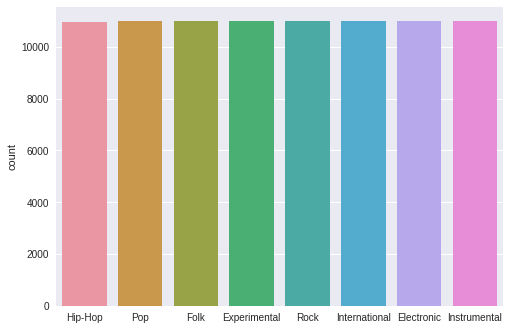

In [0]:
sns.countplot(np.array(genre_list))

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



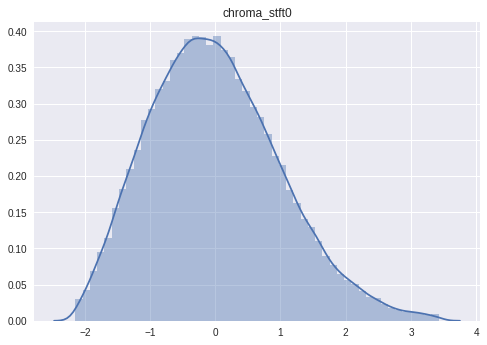

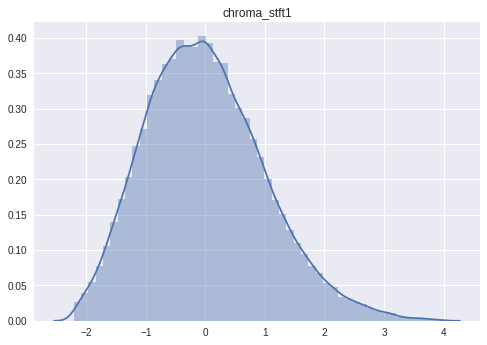

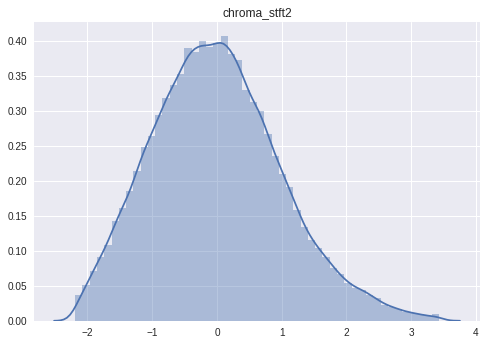

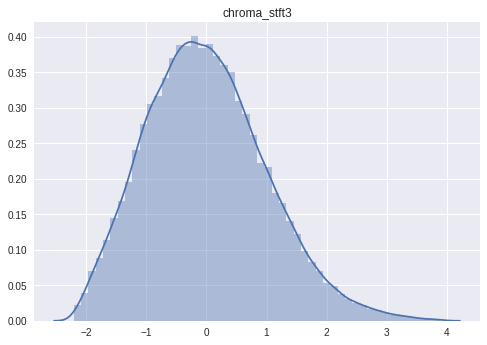

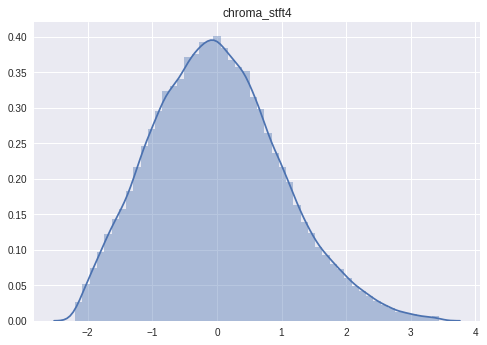

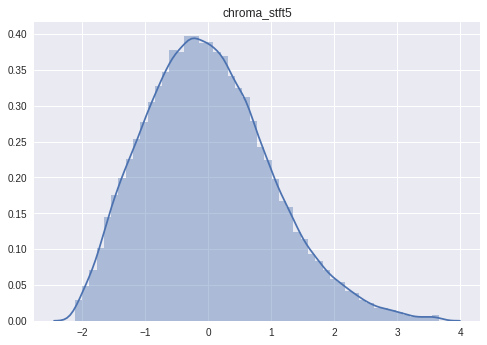

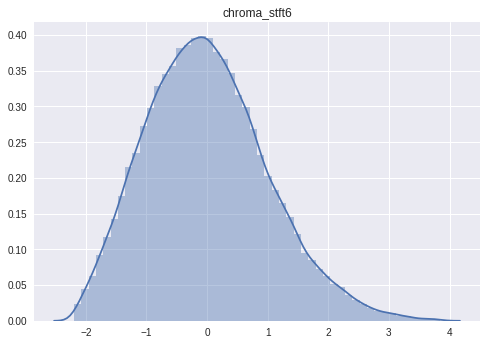

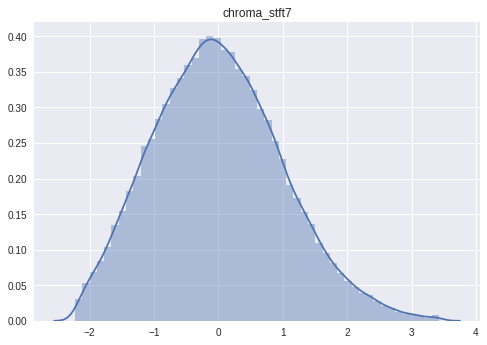

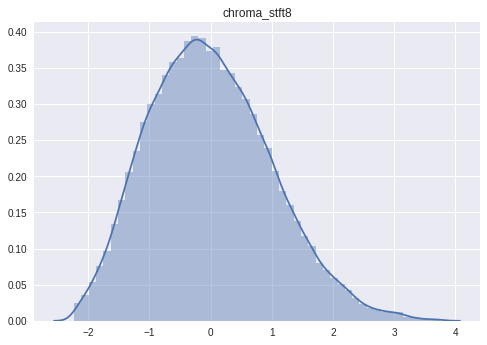

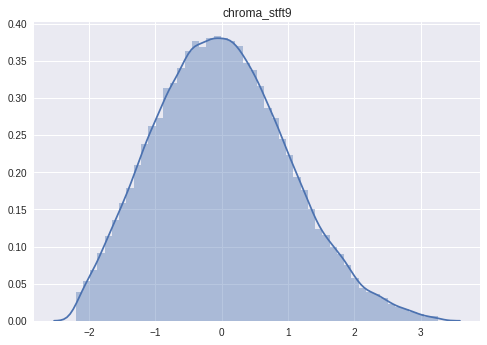

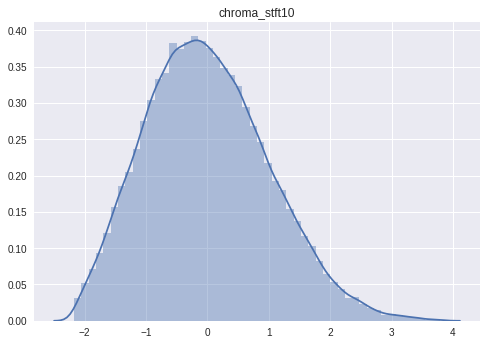

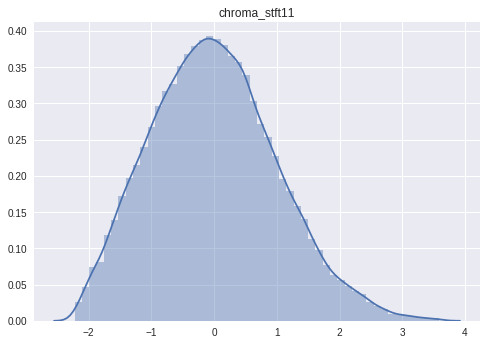

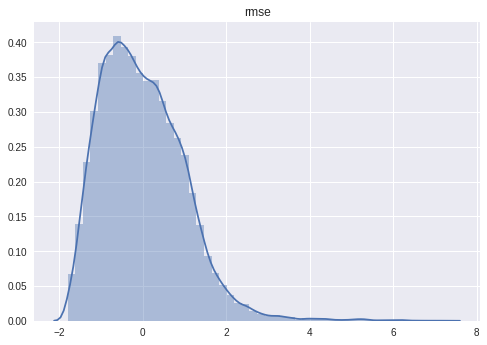

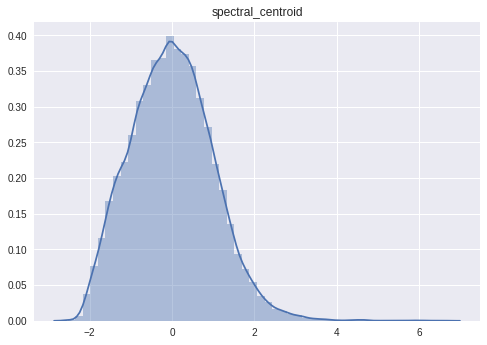

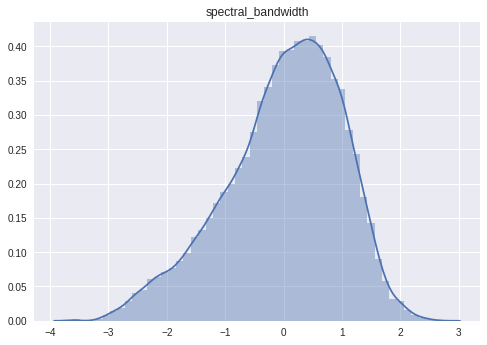

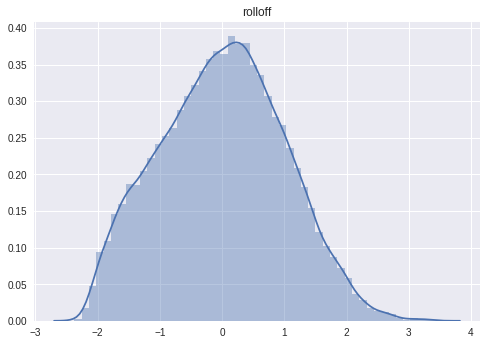

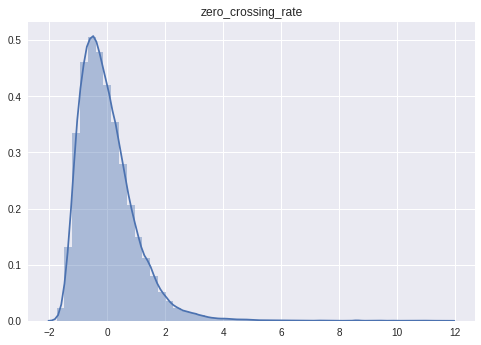

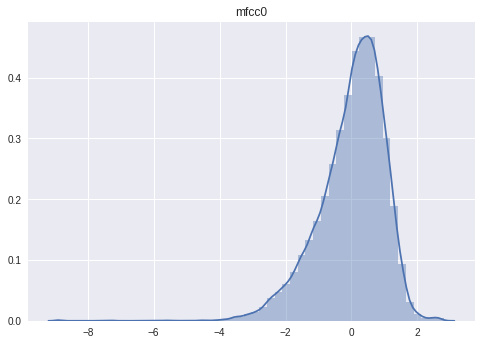

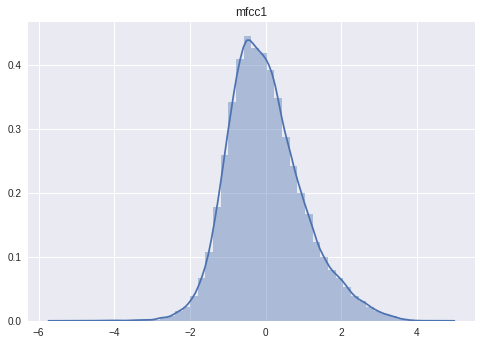

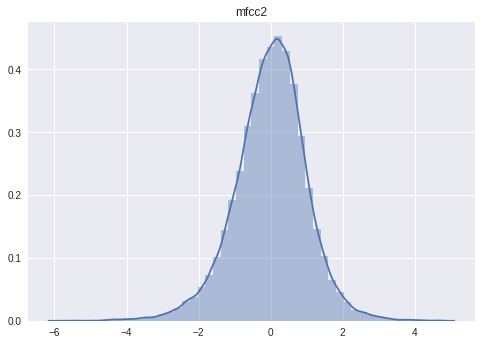

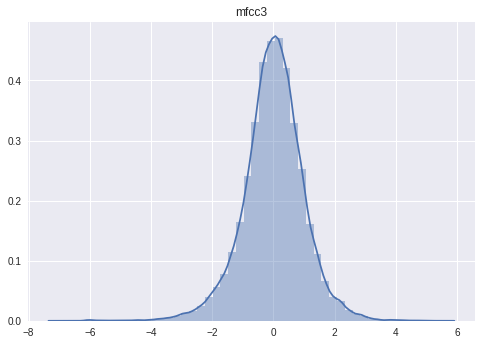

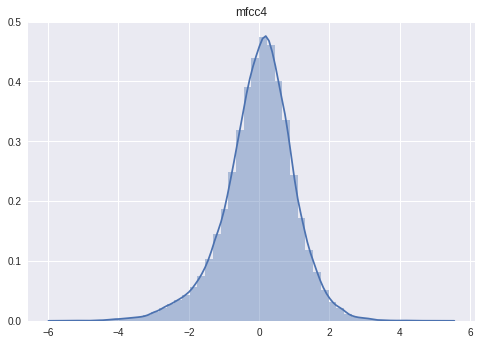

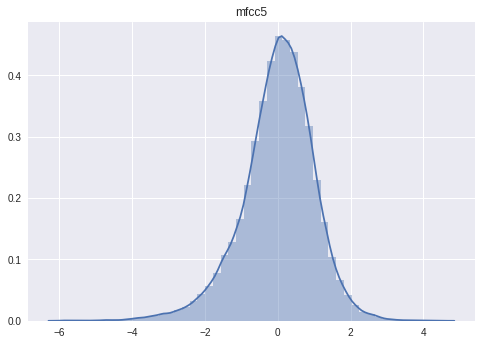

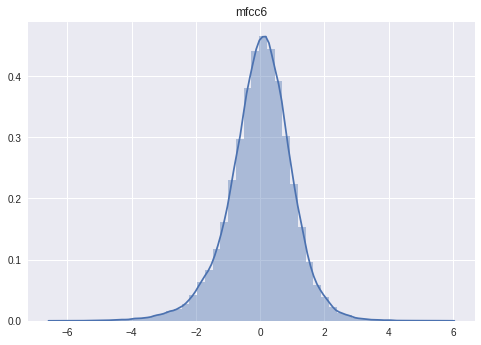

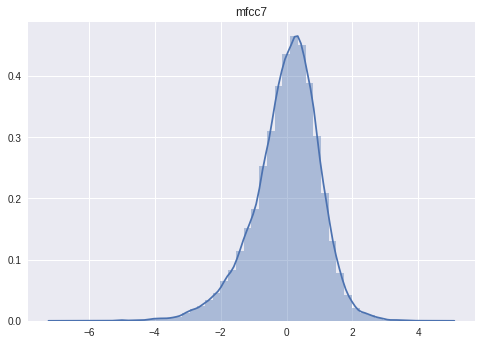

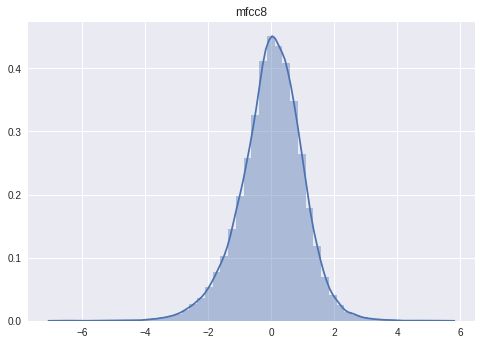

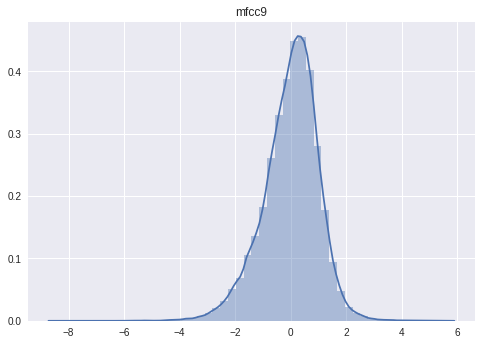

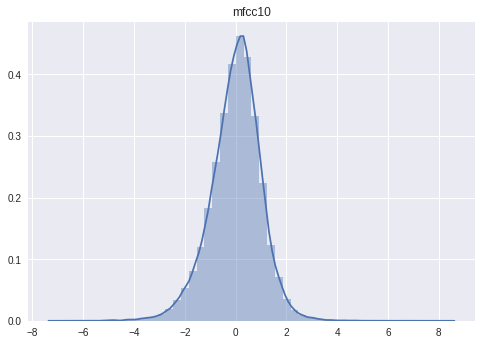

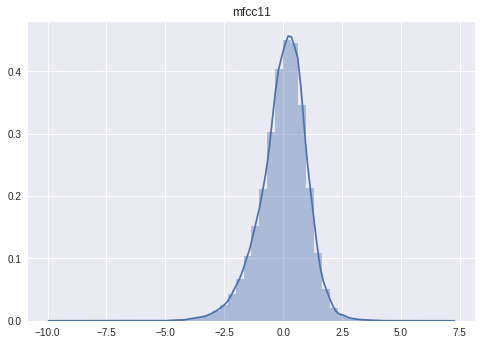

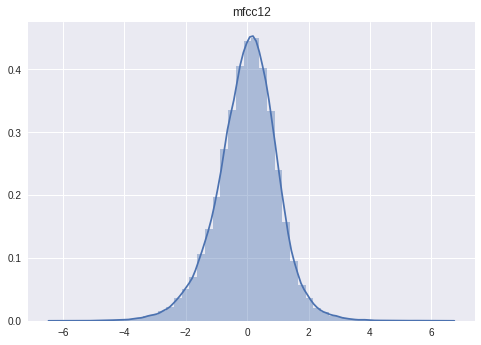

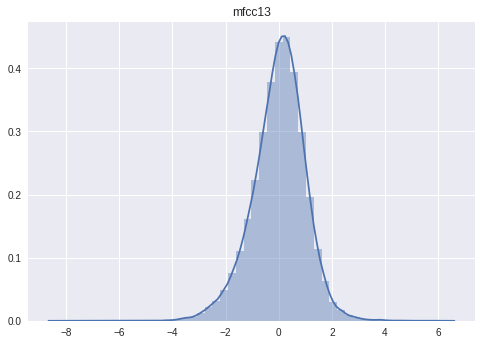

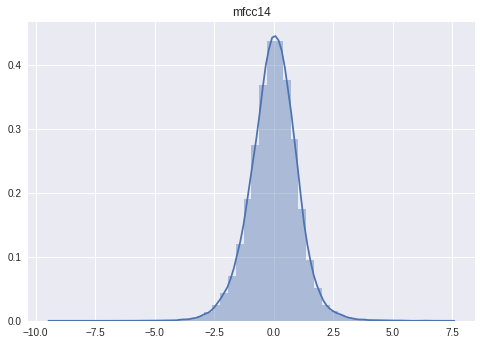

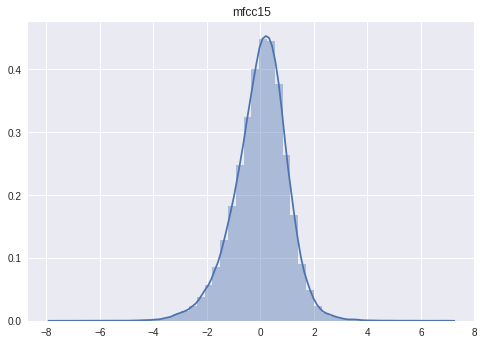

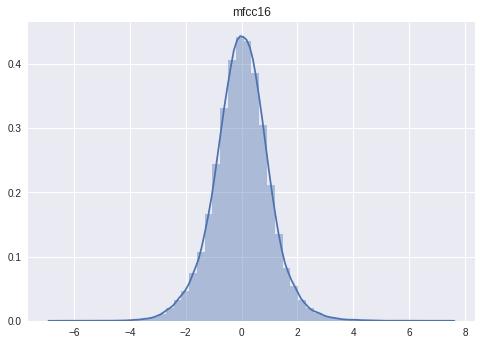

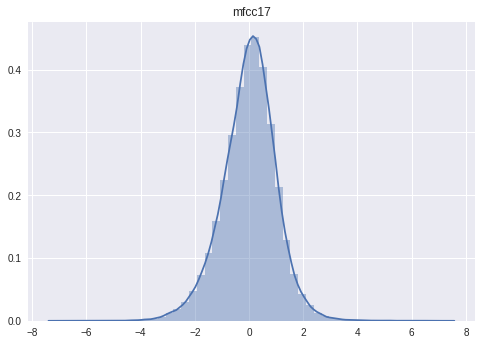

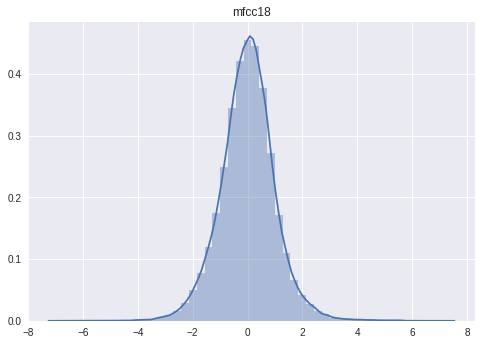

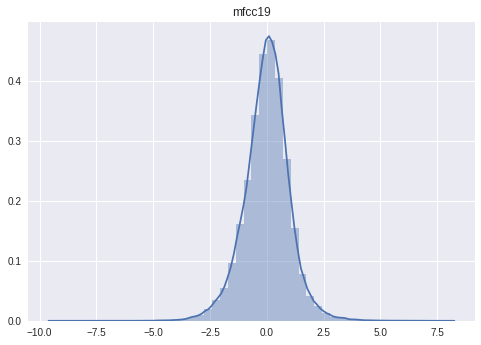

In [0]:
for i in range(X.shape[1]):
  plt.figure()
  sns.distplot(X[:,i])
  plt.title(data.columns[i])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58915, 37), (29019, 37), (58915, 8), (29019, 8))

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(x_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])
  return model


In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=1024,
                    validation_data=(X_test, y_test))

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

29019/29019 [==============================] - 2s 66us/step
Accuracy: 54.21%


In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=200, batch_size=1024, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

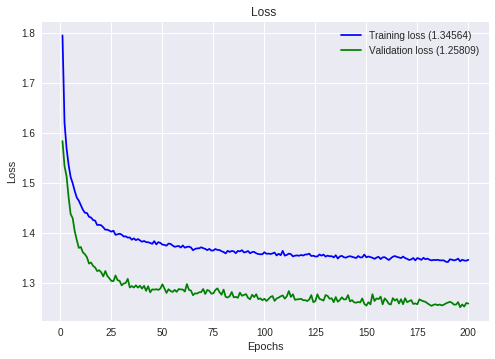

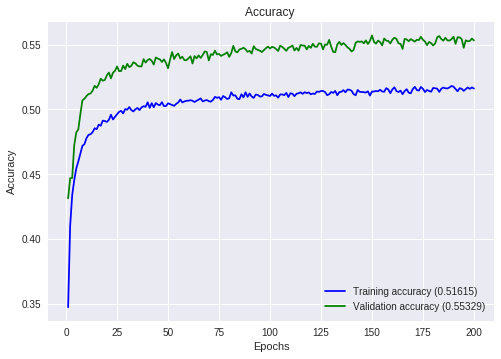

In [0]:
plot_history(hist)

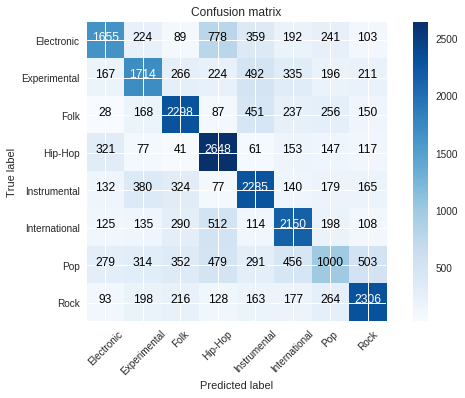

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Neural networks

In [0]:
data = pd.read_csv('/content/drive/My Drive/fma_new_data.csv')
data.head()

filename   start     end  chroma_stft0  chroma_stft1  chroma_stft2  \
0         2       0  109312      0.671731      0.496467      0.415585   
1         2   54656  163968      0.680856      0.475801      0.409628   
2         2  109312  218624      0.748234      0.445139      0.317253   
3         2  163968  273280      0.719494      0.449239      0.301587   
4         2  218624  327936      0.756944      0.454729      0.342686   

   chroma_stft3  chroma_stft4  chroma_stft5  chroma_stft6   ...       mfcc11  \
0      0.351707      0.246841      0.207594      0.251223   ...     3.404755   
1      0.356215      0.277273      0.246490      0.280779   ...     2.394101   
2      0.291285      0.246409      0.198762      0.232823   ...     0.688819   
3      0.263948      0.231405      0.211624      0.221708   ...    -0.490075   
4      0.293596      0.244110      0.232029      0.268481   ...     1.026958   

     mfcc12    mfcc13    mfcc14    mfcc15     mfcc16    mfcc17    mfcc18  \
0 -7.715089  4.425657 -5.236274 -0.651055 -10.577112 -3.374286 -2.973476   
1 -4.932249  5.508529 -3.923682  0.707046  -8.940327 -2.893473 -1.589875   
2 -1.671322  6.651651 -3.529696  1.264805  -6.898018 -0.977172 -1.385484   
3 -3.438682  6.480126 -3.744875  0.324680  -7.273698 -0.787696 -2.982801   
4 -4.299287  8.801207 -4.124980  0.610849  -9.301657 -3.132355 -3.393585   

     mfcc19    label  
0 -1.289137  Hip-Hop  
1 -0.521666  Hip-Hop  
2  0.437686  Hip-Hop  
3  0.828172  Hip-Hop  
4  0.106854  Hip-Hop  

[5 rows x 41 columns]

In [0]:
data.shape

(87934, 41)

In [0]:
filenames = skl.utils.shuffle(np.unique(data['filename']), random_state=42)
filenames[:5]

array([115812,  59724,  82931, 121740, 143057])

In [0]:
data['filename'] = pd.Categorical(data['filename'], filenames)
data = data.sort_values('filename')
data.head()

filename   start     end  chroma_stft0  chroma_stft1  chroma_stft2  \
60362   115812  273280  382592      0.302206      0.174764      0.305280   
60359   115812  109312  218624      0.122174      0.180195      0.576046   
60360   115812  163968  273280      0.301342      0.187899      0.317477   
60361   115812  218624  327936      0.393177      0.188741      0.263307   
60363   115812  327936  437248      0.363324      0.220080      0.337148   

       chroma_stft3  chroma_stft4  chroma_stft5  chroma_stft6     ...      \
60362      0.127671      0.167007      0.234634      0.229817     ...       
60359      0.217813      0.123252      0.315180      0.177280     ...       
60360      0.154430      0.245537      0.296430      0.232992     ...       
60361      0.147483      0.270140      0.328480      0.232719     ...       
60363      0.142683      0.229939      0.479071      0.264229     ...       

         mfcc11    mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17  \
60362  2.972260 -4.685666  4.356039  1.076692  9.618317  3.322368  8.180367   
60359  6.739208 -4.410659  3.252043 -6.023803  2.512782 -1.346916  5.946778   
60360  6.119943 -3.037192  4.284400 -3.029532  4.973045  1.202287  6.224922   
60361  4.796381 -4.393751  5.366810  0.440479  7.075425  1.192882  4.143395   
60363  4.585088 -5.223734  1.697318 -0.785219  6.220088  0.907015  6.163321   

         mfcc18    mfcc19       label  
60362 -0.716801  4.077470  Electronic  
60359 -1.592227  2.797595  Electronic  
60360  0.250720  5.209735  Electronic  
60361 -1.075037  6.524427  Electronic  
60363  0.000700  6.506547  Electronic  

[5 rows x 41 columns]

In [0]:
data['filename']
split_index = int(len(data) * 0.66) + 1
for i in range(split_index, len(data)):
  if data['filename'][split_index] != data['filename'][split_index - 1]:
    break
  split_index += 1

data.iloc[split_index], data.iloc[split_index - 1], split_index, split_index / len(data)

In [0]:
data = data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



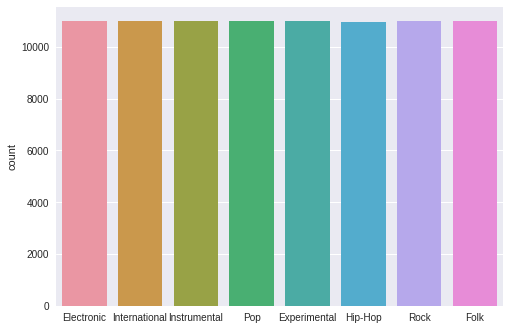

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
for i in range(X.shape[1]):
  plt.figure()
  sns.distplot(X[:,i])
  plt.title(data.columns[i])

In [0]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58047, 35), (29887, 35), (58047, 8), (29887, 8))

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(x_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(35, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
  return model


In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=1024,
                    validation_data=(X_test, y_test))

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

29887/29887 [==============================] - 3s 89us/step
Accuracy: 45.86%


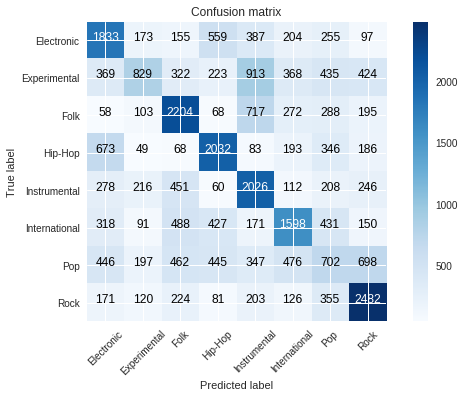

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=450, batch_size=1024, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[2:-1].tolist(), top=None)

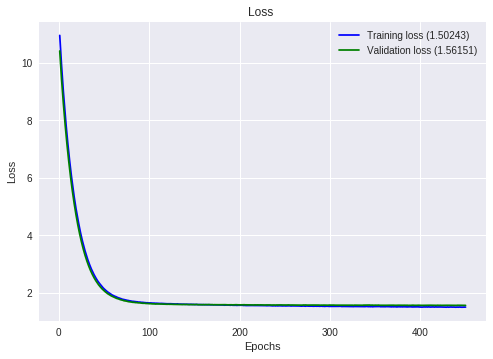

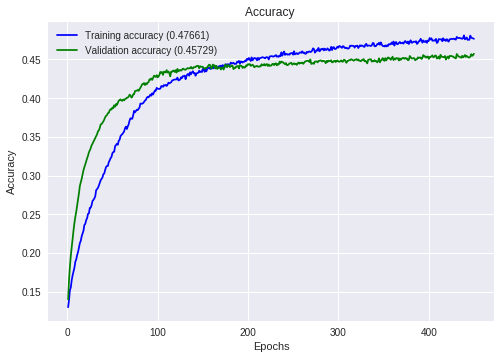

In [0]:
plot_history(hist)

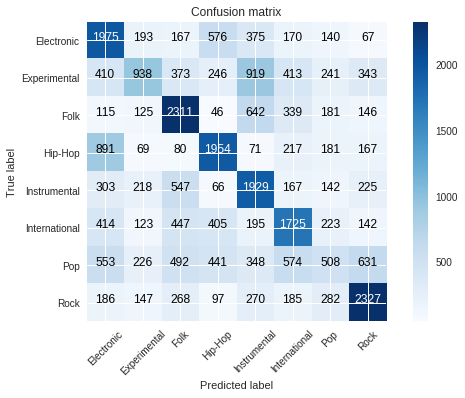

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

# GTZAN

## Download

In [0]:
download('http://opihi.cs.uvic.ca/sound/genres.tar.gz', 'gtzan.tar.gz')

[██████████████████████████████████████████████████]
Done


In [0]:
file = tarfile.open('gtzan.tar.gz', 'r:gz')
file.extractall('gtzan')
file.close()

In [0]:
gtzan_genres = np.array(['blues', 'classical', 'country', 'disco', 'hiphop',
                        'jazz', 'metal', 'pop', 'reggae', 'rock'])
gtzan_genres.shape

(10,)

In [0]:
#!rm -rf fma_small

In [0]:
!unzip -qq fma_small.zip

## Processing mp3

In [0]:
def window(data, window_size, offset):
  start = 0
  while start + window_size < len(data):
    yield start, start + window_size
    start += offset

In [0]:
def extract_infos(audio_fpath, audio_fname, window_size, n_mfcc):
  audio, sr = librosa.load(audio_fpath, mono=True, sr=22050)
  infos = []
  for (start, end) in window(audio, window_size, window_size // 2):
    y = audio[start:end]
    
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    rmse = librosa.feature.rmse(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    to_append = f'{audio_fname},{start},{end}'
    for v in chroma_stft:
        to_append += f',{np.mean(v)}'
    to_append += f',{np.mean(rmse)},{np.mean(spec_cent)},{np.mean(spec_bw)},{np.mean(rolloff)},{np.mean(zcr)}'    
    for e in mfcc:
        to_append += f',{np.mean(e)}'
    yield to_append

In [0]:
n_mfcc = 20
window_size=854*128
n_chromas = 12

In [0]:
data_file = open('/content/drive/My Drive/gtzan_new_data.csv', 'w', newline='')
header = 'filename,start,end'
for i in range(n_chromas):
    header += f',chroma_stft{i}'
header += ',rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate'
for i in range(n_mfcc):
    header += f',mfcc{i}'
header += ',label\n'

with data_file:
  data_file.write(header)


ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for genre in gtzan_genres:
  for subdir, _, files in os.walk('gtzan/genres/' + genre):
    for file in sorted(files):
      if file.lower().endswith('.au'):
        fpath = os.path.join(subdir, file)
        fname, _ = os.path.splitext(file) # (filename, extension)
        try:
          with open('/content/drive/My Drive/gtzan_new_data.csv', 'a', newline='') as data_file:
            for info in extract_infos(fpath, fname, window_size, n_mfcc):
              data_file.write(info + f',{genre}\n')
        except Exception as e:
          print('Fail', file, 'message', e, 'with path:', fpath)
          fail_cnt += 1
          continue
        ok_cnt += 1
        print('OK', file, 'with path:', fpath)
        #ci += 1
        #if ci >= count:
          #break
      else:
        continue
    #if ci >= count:
      #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))

OK blues.00000.au with path: gtzan/genres/blues/blues.00000.au
OK blues.00001.au with path: gtzan/genres/blues/blues.00001.au
OK blues.00002.au with path: gtzan/genres/blues/blues.00002.au
OK blues.00003.au with path: gtzan/genres/blues/blues.00003.au
OK blues.00004.au with path: gtzan/genres/blues/blues.00004.au
OK blues.00005.au with path: gtzan/genres/blues/blues.00005.au
OK blues.00006.au with path: gtzan/genres/blues/blues.00006.au
OK blues.00007.au with path: gtzan/genres/blues/blues.00007.au
OK blues.00008.au with path: gtzan/genres/blues/blues.00008.au
OK blues.00009.au with path: gtzan/genres/blues/blues.00009.au
OK blues.00010.au with path: gtzan/genres/blues/blues.00010.au
OK blues.00011.au with path: gtzan/genres/blues/blues.00011.au
OK blues.00012.au with path: gtzan/genres/blues/blues.00012.au
OK blues.00013.au with path: gtzan/genres/blues/blues.00013.au
OK blues.00014.au with path: gtzan/genres/blues/blues.00014.au
OK blues.00015.au with path: gtzan/genres/blues/blues.0

## Neural networks

In [0]:
data = pd.read_csv('/content/drive/My Drive/gtzan_new_data.csv')
data.head()

filename   start     end  chroma_stft0  chroma_stft1  chroma_stft2  \
0  blues.00000       0  109312      0.376166      0.385105      0.433556   
1  blues.00000   54656  163968      0.351792      0.391844      0.436995   
2  blues.00000  109312  218624      0.365565      0.420358      0.424791   
3  blues.00000  163968  273280      0.341091      0.340968      0.369315   
4  blues.00000  218624  327936      0.318576      0.320941      0.467311   

   chroma_stft3  chroma_stft4  chroma_stft5  chroma_stft6  ...       mfcc11  \
0      0.242328      0.297748      0.332061      0.362077  ...     9.058892   
1      0.259504      0.291049      0.352361      0.415536  ...     8.378756   
2      0.252823      0.254887      0.305083      0.303294  ...    10.221469   
3      0.223925      0.285187      0.347278      0.285867  ...    10.800084   
4      0.256231      0.251895      0.360614      0.337568  ...    13.566429   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0 -5.594772  7.098390 -8.768197 -2.195857 -3.914673  0.760242 -2.895125   
1 -7.130909  7.653516 -7.042454  1.523854 -4.995149  1.069871 -2.531226   
2 -3.283244  7.702187 -2.930592  3.831177 -2.264132  0.229388 -2.812740   
3 -3.854065  7.388019 -6.693757  1.017784 -1.880017  1.309402 -2.489344   
4 -6.409681  6.717931 -8.807538  1.010584 -1.747323  1.645907 -3.229617   

     mfcc19  label  
0  2.815366  blues  
1  5.263336  blues  
2  2.336686  blues  
3  1.974294  blues  
4  1.485549  blues  

[5 rows x 41 columns]

In [0]:
data.shape

(11000, 41)

In [0]:
data = data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
np.unique(y)

array([0., 1.], dtype=float32)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



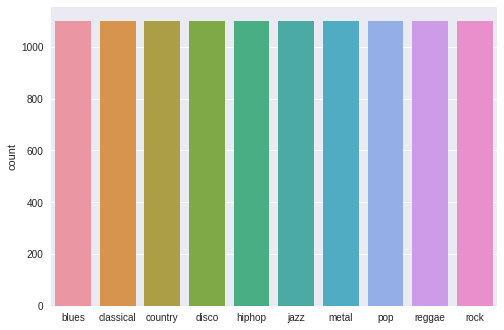

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
for i in range(X.shape[1]):
  plt.figure()
  sns.distplot(X[:,i])
  plt.title(data.columns[i])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7370, 37), (3630, 37), (7370, 10), (3630, 10))

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(x_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])
  return model


In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=1024,
                    validation_data=(X_test, y_test))

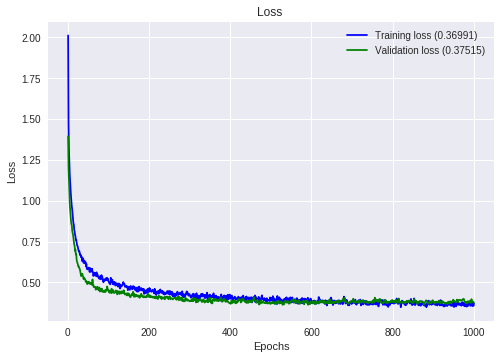

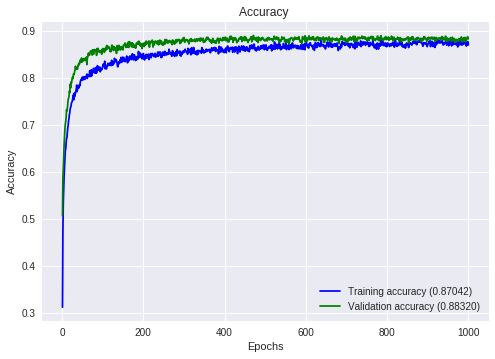

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

3630/3630 [==============================] - 0s 100us/step
Accuracy: 88.32%


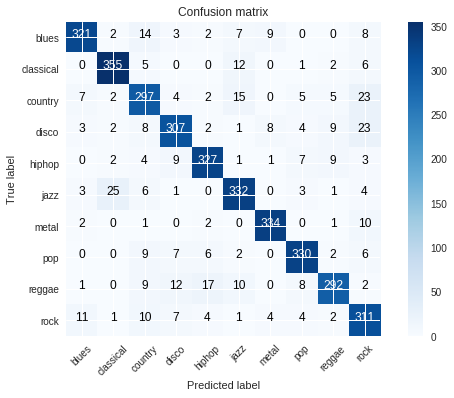

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=200, batch_size=1024, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

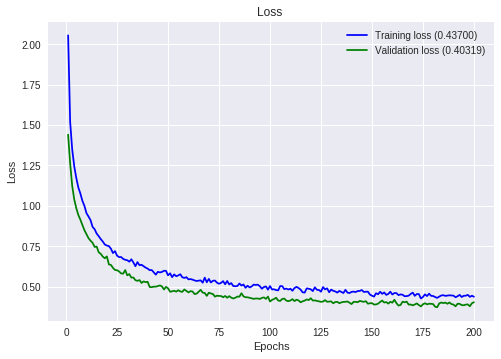

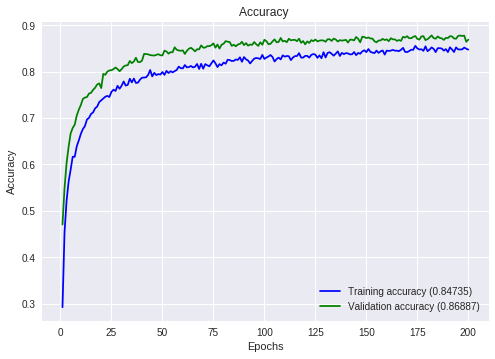

In [0]:
plot_history(hist)

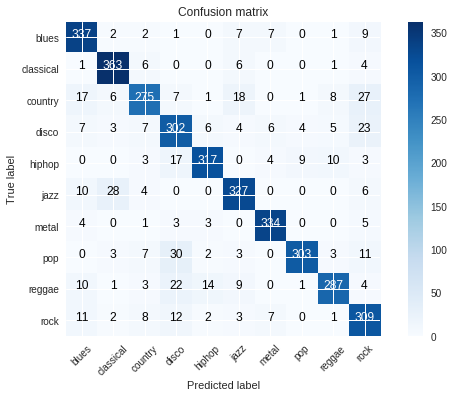

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Neural networks

In [0]:
data = pd.read_csv('/content/drive/My Drive/gtzan_new_data.csv')
data.head()

filename   start     end  chroma_stft0  chroma_stft1  chroma_stft2  \
0  blues.00000       0  109312      0.376166      0.385105      0.433556   
1  blues.00000   54656  163968      0.351792      0.391844      0.436995   
2  blues.00000  109312  218624      0.365565      0.420358      0.424791   
3  blues.00000  163968  273280      0.341091      0.340968      0.369315   
4  blues.00000  218624  327936      0.318576      0.320941      0.467311   

   chroma_stft3  chroma_stft4  chroma_stft5  chroma_stft6  ...       mfcc11  \
0      0.242328      0.297748      0.332061      0.362077  ...     9.058892   
1      0.259504      0.291049      0.352361      0.415536  ...     8.378756   
2      0.252823      0.254887      0.305083      0.303294  ...    10.221469   
3      0.223925      0.285187      0.347278      0.285867  ...    10.800084   
4      0.256231      0.251895      0.360614      0.337568  ...    13.566429   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0 -5.594772  7.098390 -8.768197 -2.195857 -3.914673  0.760242 -2.895125   
1 -7.130909  7.653516 -7.042454  1.523854 -4.995149  1.069871 -2.531226   
2 -3.283244  7.702187 -2.930592  3.831177 -2.264132  0.229388 -2.812740   
3 -3.854065  7.388019 -6.693757  1.017784 -1.880017  1.309402 -2.489344   
4 -6.409681  6.717931 -8.807538  1.010584 -1.747323  1.645907 -3.229617   

     mfcc19  label  
0  2.815366  blues  
1  5.263336  blues  
2  2.336686  blues  
3  1.974294  blues  
4  1.485549  blues  

[5 rows x 41 columns]

In [0]:
data.shape

(11000, 41)

In [0]:
filenames = skl.utils.shuffle(np.unique(data['filename']), random_state=42)
filenames[:5]

array(['jazz.00021', 'pop.00037', 'pop.00040', 'metal.00060',
       'hiphop.00011'], dtype=object)

In [0]:
data['filename'] = pd.Categorical(data['filename'], filenames)
data = data.sort_values('filename')
data.head()

filename   start     end  chroma_stft0  chroma_stft1  chroma_stft2  \
5731  jazz.00021       0  109312      0.300785      0.324195      0.517149   
5732  jazz.00021   54656  163968      0.356750      0.344284      0.493353   
5733  jazz.00021  109312  218624      0.376021      0.424393      0.452447   
5734  jazz.00021  163968  273280      0.345491      0.363095      0.372594   
5735  jazz.00021  218624  327936      0.277544      0.300015      0.357891   

      chroma_stft3  chroma_stft4  chroma_stft5  chroma_stft6  ...    \
5731      0.460012      0.516100      0.535585      0.406002  ...     
5732      0.531334      0.474448      0.451127      0.389475  ...     
5733      0.493959      0.555942      0.531861      0.493650  ...     
5734      0.385471      0.531476      0.578112      0.460883  ...     
5735      0.323319      0.482861      0.520938      0.403444  ...     

         mfcc11    mfcc12     mfcc13    mfcc14     mfcc15    mfcc16    mfcc17  \
5731  13.691510 -7.895130  10.325357 -5.928385  11.382670 -5.943262  0.159542   
5732  12.389080 -8.915271   8.387526 -3.131659  12.724865 -4.522689 -1.424575   
5733  11.643842 -9.592621   5.610496 -4.327473  11.391618 -4.514002 -1.290166   
5734  11.641785 -8.451412   7.115411 -6.156837   9.458931 -4.514853  2.715120   
5735   9.484645 -7.626350   6.284039 -4.589919   6.916386 -5.126703  1.798866   

         mfcc18    mfcc19  label  
5731  -7.274626  2.577217   jazz  
5732 -10.106324  0.334107   jazz  
5733  -7.363026  1.459528   jazz  
5734  -0.260767  4.217943   jazz  
5735   0.107162  3.835286   jazz  

[5 rows x 41 columns]

In [0]:
data['filename']
split_index = int(len(data) * 0.66) + 1
for i in range(split_index, len(data)):
  if data['filename'][split_index] != data['filename'][split_index - 1]:
    break
  split_index += 1

data.iloc[split_index], data.iloc[split_index - 1], split_index, split_index / len(data)

In [0]:
data = data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
np.unique(y)

array([0., 1.], dtype=float32)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



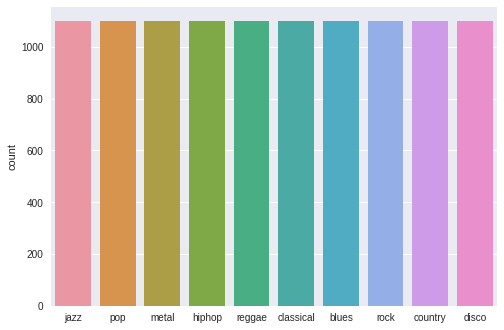

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
for i in range(X.shape[1]):
  plt.figure()
  sns.distplot(X[:,i])
  plt.title(data.columns[i])

In [0]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7271, 37), (3729, 37), (7271, 10), (3729, 10))

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(x_shape,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(35, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(12, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(layers.Dropout(0.2))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])
  return model


In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=1024,
                    validation_data=(X_test, y_test))

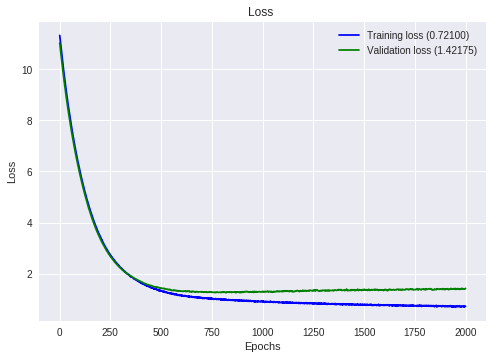

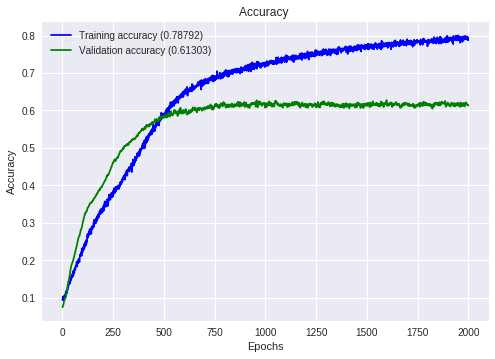

In [0]:
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

3729/3729 [==============================] - 0s 100us/step
Accuracy: 61.30%


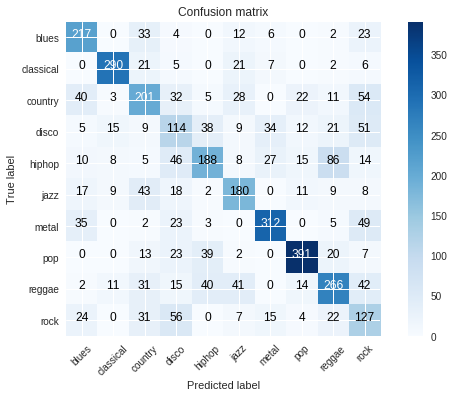

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_test_classes = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=2000, batch_size=1024, validation_data=(X_test, y_test))    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

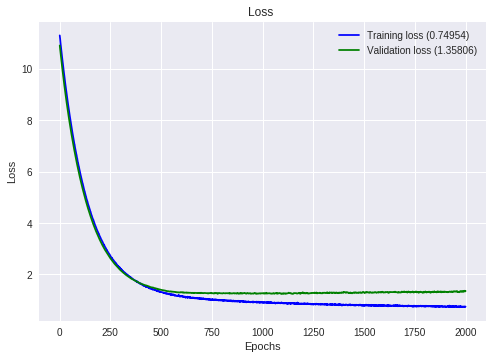

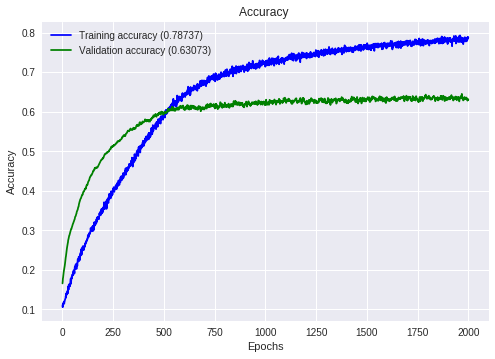

In [0]:
plot_history(hist)

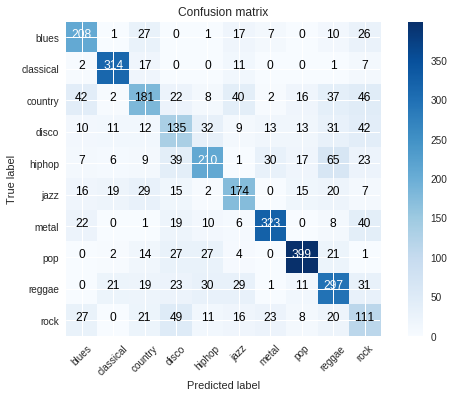

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

# Results

## Uploading mp3

In [0]:
uploaded = gc.files.upload()

Saving Beethoven Moonlight Sonata.mp3 to Beethoven Moonlight Sonata.mp3


KeyboardInterrupt: ignored

In [0]:
X_names = []
for name, data in uploaded.items():
  X_names.append(name)

In [0]:
for name in X_names:
  x, sr = librosa.load(name, sr=None, mono=True)
  print(name, 'Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

  start, end = 0, 30
  ipd.display(ipd.Audio(data=x[start*sr:end*sr], rate=sr))

free_bird_cut_1.mp3 Duration: 27.40s, 1208340 samples


free_bird_cut_2.mp3 Duration: 22.10s, 974639 samples


free_bird_cut_3.mp3 Duration: 22.60s, 996660 samples


In [0]:
X_names = ['free_bird_cut_1.mp3', 'free_bird_cut_2.mp3', 'free_bird_cut_3.mp3',
           'instumental_cut_1.mp3', 'instumental_cut_2.mp3', 'instumental_cut_3.mp3',
          'rap_god_cut_1.mp3', 'rap_god_cut_2.mp3', 'rap_god_cut_3.mp3', 
          'shine on_cut_1.mp3', 'shine on_cut_2.mp3', 'shine on_cut_3.mp3',
          'free bird.mp3', 'shine on3.mp3', 'Beethoven Moonlight Sonata.mp3']

In [0]:
data_file = open('/content/drive/My Drive/fma_upload_test_data.csv', 'w', newline='')
header = 'filename,start,end'
for i in range(n_chromas):
    header += f',chroma_stft{i}'
header += ',rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate'
for i in range(n_mfcc):
    header += f',mfcc{i}'
header += '\n'

with data_file:
  data_file.write(header)

with open('/content/drive/My Drive/fma_upload_test_data.csv', 'a', newline='') as data_file:
  for name in X_names:
    for info in extract_infos(name, name, window_size, n_mfcc):
      data_file.write(info + '\n')
    print(f'Processing {name} done.')

Processing Beethoven Moonlight Sonata.mp3 done.
Processing free bird.mp3 done.
Processing free_bird_cut_1.mp3 done.
Processing free_bird_cut_2.mp3 done.
Processing free_bird_cut_3.mp3 done.
Processing instumental_cut_1.mp3 done.
Processing instumental_cut_2.mp3 done.
Processing instumental_cut_3.mp3 done.
Processing rap_god_cut_1.mp3 done.
Processing rap_god_cut_2.mp3 done.
Processing rap_god_cut_3.mp3 done.
Processing shine on_cut_1.mp3 done.
Processing shine on_cut_2.mp3 done.
Processing shine on_cut_3.mp3 done.
Processing shine on3.mp3 done.


## FMA

In [0]:
train_data = skl.utils.shuffle(pd.read_csv('/content/drive/My Drive/fma_new_data.csv'))

In [0]:
test_data = pd.read_csv('/content/drive/My Drive/fma_upload_test_data.csv')

In [0]:
train_data = train_data.drop(['filename', 'start', 'end'], axis=1)
test_data_names = test_data['filename']
test_data = test_data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = train_data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X_train = scaler.fit_transform(np.array(train_data.iloc[:, :-1], dtype=float))
X_test = scaler.transform(test_data)

In [0]:
X_train.shape, y.shape, X_test.shape

((87934, 37), (87934, 8), (778, 37))

In [0]:
my_model = get_model(X_train.shape[1], y.shape[1])
history = my_model.fit(X_train, y, epochs=400, batch_size=1024)

Epoch 1/400
87934/87934 [==============================] - 5s 52us/step - loss: 1.7315 - acc: 0.3710
Epoch 2/400
87934/87934 [==============================] - 1s 12us/step - loss: 1.5737 - acc: 0.4305
Epoch 3/400
87934/87934 [==============================] - 1s 13us/step - loss: 1.5279 - acc: 0.4498
Epoch 4/400
87934/87934 [==============================] - 1s 12us/step - loss: 1.5006 - acc: 0.4590
Epoch 5/400
87934/87934 [==============================] - 1s 12us/step - loss: 1.4824 - acc: 0.4646
Epoch 6/400
87934/87934 [==============================] - 1s 12us/step - loss: 1.4665 - acc: 0.4746
Epoch 7/400
87934/87934 [==============================] - 1s 13us/step - loss: 1.4555 - acc: 0.4744
Epoch 8/400
87934/87934 [==============================] - 1s 13us/step - loss: 1.4480 - acc: 0.4804
Epoch 9/400
87934/87934 [==============================] - 1s 13us/step - loss: 1.4422 - acc: 0.4812
Epoch 10/400
87934/87934 [==============================] - 1s 13us/step - loss: 1.4334 - a

In [0]:
result = my_model.predict(X_test)

In [0]:
y_test = []
for name in X_names:
  idx = test_data_names.index[test_data_names == name]
  values, counts = np.unique(np.argmax(result[idx], axis=0), return_counts=True)
  
  if len(counts[counts == np.max(counts)]) == 1:
    y_test.append(np.unravel_index(values[np.argmax(counts)], result[idx].shape)[1])
  else:
    y_test.append(np.unravel_index(np.argmax(result[idx]), result[idx].shape)[1])

y_label = encoder.inverse_transform(y_test)

print('Predicted:')
for i in range(len(X_names)):
  print(X_names[i], y_label[i])

Predicted:
Beethoven Moonlight Sonata.mp3 Electronic
free bird.mp3 Instrumental
free_bird_cut_1.mp3 Rock
free_bird_cut_2.mp3 International
free_bird_cut_3.mp3 Experimental
instumental_cut_1.mp3 Folk
instumental_cut_2.mp3 Pop
instumental_cut_3.mp3 Rock
rap_god_cut_1.mp3 Electronic
rap_god_cut_2.mp3 Pop
rap_god_cut_3.mp3 Experimental
shine on_cut_1.mp3 Folk
shine on_cut_2.mp3 Folk
shine on_cut_3.mp3 Folk
shine on3.mp3 Instrumental


## GTZAN

In [0]:
train_data = skl.utils.shuffle(pd.read_csv('/content/drive/My Drive/gtzan_new_data.csv'))

In [0]:
test_data = pd.read_csv('/content/drive/My Drive/fma_upload_test_data.csv')

In [0]:
train_data = train_data.drop(['filename', 'start', 'end'], axis=1)
test_data_names = test_data['filename']
test_data = test_data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = train_data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X_train = scaler.fit_transform(np.array(train_data.iloc[:, :-1], dtype=float))
X_test = scaler.transform(test_data)

In [0]:
X_train.shape, y.shape, X_test.shape

((11000, 37), (11000, 10), (778, 37))

In [0]:
my_model = get_model(X_train.shape[1], y.shape[1])
history = my_model.fit(X_train, y, epochs=600, batch_size=512)

Epoch 1/600
11000/11000 [==============================] - 1s 73us/step - loss: 1.7318 - acc: 0.3853
Epoch 2/600
11000/11000 [==============================] - 0s 18us/step - loss: 1.2625 - acc: 0.5447
Epoch 3/600
11000/11000 [==============================] - 0s 19us/step - loss: 1.1338 - acc: 0.6013
Epoch 4/600
11000/11000 [==============================] - 0s 18us/step - loss: 1.0399 - acc: 0.6385
Epoch 5/600
11000/11000 [==============================] - 0s 19us/step - loss: 0.9732 - acc: 0.6629
Epoch 6/600
11000/11000 [==============================] - 0s 20us/step - loss: 0.9125 - acc: 0.6808
Epoch 7/600
11000/11000 [==============================] - 0s 19us/step - loss: 0.8546 - acc: 0.7005
Epoch 8/600
11000/11000 [==============================] - 0s 20us/step - loss: 0.8242 - acc: 0.7152
Epoch 9/600
11000/11000 [==============================] - 0s 19us/step - loss: 0.7923 - acc: 0.7257
Epoch 10/600
11000/11000 [==============================] - 0s 20us/step - loss: 0.7661 - a

In [0]:
result = my_model.predict(X_test)

In [0]:
y_test = []
for name in X_names:
  idx = test_data_names.index[test_data_names == name]
  values, counts = np.unique(np.argmax(result[idx], axis=0), return_counts=True)
  
  if len(counts[counts == np.max(counts)]) == 1:
    y_test.append(np.unravel_index(values[np.argmax(counts)], result[idx].shape)[1])
  else:
    y_test.append(np.unravel_index(np.argmax(result[idx]), result[idx].shape)[1])

y_label = encoder.inverse_transform(y_test)

print('Predicted:')
for i in range(len(X_names)):
  print(X_names[i], y_label[i])

Predicted:
free_bird_cut_1.mp3 rock
free_bird_cut_2.mp3 metal
free_bird_cut_3.mp3 hiphop
instumental_cut_1.mp3 metal
instumental_cut_2.mp3 reggae
instumental_cut_3.mp3 reggae
rap_god_cut_1.mp3 rock
rap_god_cut_2.mp3 pop
rap_god_cut_3.mp3 hiphop
shine on_cut_1.mp3 classical
shine on_cut_2.mp3 hiphop
shine on_cut_3.mp3 reggae
free bird.mp3 hiphop
shine on3.mp3 classical
Beethoven Moonlight Sonata.mp3 metal
